# Logistic Regression for Classifying Emails as Spam or Not Spam

This notebook builds and evaluates logistic regression models to classify email messages as **spam (1)** or **non-spam (0)** using the **UCI Spambase** dataset.

The workflow includes:
- Basic data validation (types, missingness, duplicates)
- Exploratory analysis to understand feature distributions and class balance
- Feature selection (mutual information) as a baseline approach
- Comparison of **regularized vs. unregularized** logistic regression
- Log transformation to address strong right-skew in predictors
- Diagnostics focused on key logistic regression assumptions (e.g., multicollinearity)

The goal is a model that performs well while remaining interpretable and aligned with the practical cost of errors (especially false positives).


In [ ]:
## Setup

The notebook uses common data science libraries plus `ucimlrepo` to fetch the dataset directly from the UCI repository.

**Note:** `sklearn` is deprecated on PyPI; the correct package is `scikit-learn`. If needed, install it with `pip install scikit-learn`.


In [ ]:
# install packages (if necessary)
%pip install scipy
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates f

## Imports

I load core libraries for:
- data manipulation (`pandas`, `numpy`)
- visualization (`matplotlib`, `seaborn`)
- modeling and evaluation (`scikit-learn`)
- statistical testing and diagnostics (`scipy`, `statsmodels`)

In [2]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from pathlib import Path
import statsmodels.api as sm
import re

from patsy import dmatrices

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from scipy.stats import ks_2samp

## Data source

The dataset is pulled programmatically via `ucimlrepo` so the notebook stays reproducible and does not rely on local files.


In [3]:
# install the ucimlrepo package
import sys
!{sys.executable} -m pip install ucimlrepo

## Load the Spambase dataset (UCI)

Spambase contains **57 engineered predictors** derived from email text patterns (word frequencies, character frequencies, and capital-letter run statistics).  
The target variable is `Class`: **1 = spam**, **0 = not spam**.


In [4]:
# import the dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
# metadata 
print(spambase.metadata) 
  
# variable information 
print(spambase.variables) 


{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

## Quick inspection

Before modeling, I confirm that:
- features load correctly and have the expected shape
- the target column is present and binary

In [5]:
# Examine the datasets
spambase.data.features.head()


word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0             0.00            0.00  ...                   0.0         0.00   
1             0.00            0.94  ...                   0.0         0.00   
2             0.64            0.25  ...                   0.0         0.01   
3             0.31            0.63  ...                   0.0         0.00   
4             0.31            0.63  ...                   0.0         0.00   

   char_freq_(  char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0        0.000          0.0        0.778        0.000        0.000   
1        0.132          0.0        0.372        0.180        0.048   
2        0.143          0.0        0.276        0.184        0.010   
3        0.137          0.0        0.137        0.000        0.000   
4        0.135          0.0        0.135        0.000        0.000   

   capital_run_length_average  capital_run_length_longest  \
0                       3.756                          61   
1                       5.114                         101   
2                       9.821                         485   
3                       3.537                          40   
4                       3.537                          40   

   capital_run_length_total  
0                       278  
1                      1028  
2                      2259  
3                       191  
4                       191  

[5 rows x 57 columns]

57 independent variables

In [6]:
spambase.data.targets.head()

Class
0      1
1      1
2      1
3      1
4      1

## Create analysis table

For EDA and preprocessing, I combine the feature matrix `X` and the target `y` into one DataFrame.

In [7]:
# combine features and target in one dataframe for analysis
df = pd.concat([X,y], axis=1)

In [8]:
# examine dataframe
df.head()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1             0.00            0.94  ...         0.00        0.132   
2             0.64            0.25  ...         0.01        0.143   
3             0.31            0.63  ...         0.00        0.137   
4             0.31            0.63  ...         0.00        0.135   

   char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0          0.0        0.778        0.000        0.000   
1          0.0        0.372        0.180        0.048   
2          0.0        0.276        0.184        0.010   
3          0.0        0.137        0.000        0.000   
4          0.0        0.135        0.000        0.000   

   capital_run_length_average  capital_run_length_longest  \
0                       3.756                          61   
1                       5.114                         101   
2                       9.821                         485   
3                       3.537                          40   
4                       3.537                          40   

   capital_run_length_total  Class  
0                       278      1  
1                      1028      1  
2                      2259      1  
3                       191      1  
4                       191      1  

[5 rows x 58 columns]

## Exploratory Data Analysis (EDA)

## Dataset size

I start by confirming the number of rows and columns to validate the fetch and establish the modeling context (sample size vs. feature count).


In [9]:
# Get dimensions
print("Shape:", df.shape)

Shape: (4601, 58)


-  Notes
    -  4,601 instances 
    - 57 independent variables, 1 dependent variable (spam = 1, not spam = 0)

## Feature granularity

This check gives a quick sense of how sparse/continuous the predictors are. Many frequency-based features have many zeros and a long right tail, which can influence scaling and model stability.

In [10]:
# Check data types
print("Data Types: \n", df.dtypes)

Data Types: 
 word_freq_make                float64
word_freq_address             float64
word_freq_all                 float64
word_freq_3d                  float64
word_freq_our                 float64
word_freq_over                float64
word_freq_remove              float64
word_freq_internet            float64
word_freq_order               float64
word_freq_mail                float64
word_freq_receive             float64
word_freq_will                float64
word_freq_people              float64
word_freq_report              float64
word_freq_addresses           float64
word_freq_free                float64
word_freq_business            float64
word_freq_email               float64
word_freq_you                 float64
word_freq_credit              float64
word_freq_your                float64
word_freq_font                float64
word_freq_000                 float64
word_freq_money               float64
word_freq_hp                  float64
word_freq_hpl                 float6

## Data types

Logistic regression works well with numeric inputs.  
Here I confirm all predictors are numeric (floats/ints) and the target is encoded as integers.

In [11]:
# Get unique values for each column
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")

word_freq_make: 142
word_freq_address: 171
word_freq_all: 214
word_freq_3d: 43
word_freq_our: 255
word_freq_over: 141
word_freq_remove: 173
word_freq_internet: 170
word_freq_order: 144
word_freq_mail: 245
word_freq_receive: 113
word_freq_will: 316
word_freq_people: 158
word_freq_report: 133
word_freq_addresses: 118
word_freq_free: 253
word_freq_business: 197
word_freq_email: 229
word_freq_you: 575
word_freq_credit: 148
word_freq_your: 401
word_freq_font: 99
word_freq_000: 164
word_freq_money: 143
word_freq_hp: 395
word_freq_hpl: 281
word_freq_george: 240
word_freq_650: 200
word_freq_lab: 156
word_freq_labs: 179
word_freq_telnet: 128
word_freq_857: 106
word_freq_data: 184
word_freq_415: 110
word_freq_85: 177
word_freq_technology: 159
word_freq_1999: 188
word_freq_parts: 53
word_freq_pm: 163
word_freq_direct: 125
word_freq_cs: 108
word_freq_meeting: 186
word_freq_original: 136
word_freq_project: 160
word_freq_re: 230
word_freq_edu: 227
word_freq_table: 38
word_freq_conference: 106
char_f

## Missing Values

Spambase is expected to have no missing values. I confirm that here so later modeling steps don’t require imputation.

In [12]:
# Check for missing values
print("Missing Values: \n", df.isnull().sum())

Missing Values: 
 word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet      

## Duplicate rows

Duplicate emails can bias evaluation by leaking identical observations into both train and test sets.  
I identify duplicates and then remove them to ensure performance estimates reflect generalization to *unique* emails.

In [13]:
# Check for duplicates
print("Duplicate Rows: \n", df.duplicated().sum())

Duplicate Rows: 
 391


In [14]:
# Find all rows that are duplicated
dup_rows = df[df.duplicated(keep=False)]

# How many such rows?
print(f"Total duplicate rows (including first occurrences): {len(dup_rows)}")

# Peek at the first few
print(dup_rows.head(10))


Total duplicate rows (including first occurrences): 571
     word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
24             0.00                0.0           0.00           0.0   
26             0.00                0.0           0.00           0.0   
101            0.00                0.0           0.64           0.0   
102            0.00                0.0           0.00           0.0   
103            0.00                0.0           0.64           0.0   
104            0.00                0.0           0.00           0.0   
105            0.00                0.0           0.64           0.0   
106            0.00                0.0           0.00           0.0   
108            0.00                0.0           0.00           0.0   
116            0.05                0.3           0.40           0.0   

     word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
24             0.0            0.00               0.0                0.00   
26        

## Deduplicate

I keep the first occurrence of each duplicate row and reset the index for a clean working dataset.

In [15]:
# Remove duplicates, keeping only the first occurrence
df_clean = df.drop_duplicates(keep='first').reset_index(drop=True)
print(f"Rows after deduplication: {df_clean.shape[0]}")

Rows after deduplication: 4210


## Target distribution

Class balance affects how metrics should be interpreted.  
Because spam detection is sensitive to false positives, I later emphasize precision/recall and ROC-AUC in addition to accuracy.

In [16]:
# Get value counts of categorical data
print("Spam/Not Spam: \n", df_clean["Class"].value_counts())

Spam/Not Spam: 
 Class
0    2531
1    1679
Name: count, dtype: int64


After removing duplicates, we are left with 4,210 unique emails: 1,679 spam and 2,531 not spam. 

## Summary statistics

Many predictors have a median of 0, with a small number of emails showing large values.  
This pattern suggests:
- heavy right-skew and outliers (especially for `capital_run_length_*`)
- the need for scaling and potentially transformation (e.g., `log1p`)
- regularization may help when many weak predictors are present

In [17]:
# Count, mean, standard deviation, min/max, quartiles
print("\nCount, mean, std, min, max, quartiles:\n", df_clean.describe())


Count, mean, std, min, max, quartiles:
        word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     4210.000000        4210.000000    4210.000000   4210.000000   
mean         0.104366           0.112656       0.291473      0.063078   
std          0.300005           0.454260       0.515719      1.352487   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.000000      0.000000   
75%          0.000000           0.000000       0.440000      0.000000   
max          4.540000          14.280000       5.100000     42.810000   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    4210.000000     4210.000000       4210.000000         4210.000000   
mean        0.325321        0.096656          0.117475            0.108000   
std         0.687805        0.276030          0.397284            0

Notes on summary statistics:
-  For most 'word_freq_X' and 'char_freq_X' variables, the median, 25th, and often 75th percentile are all 0; most emails do not contain the vast majority of these words or characters; only a small fraction of messages include them. Try using regularization (L1) to identify meaningful predictors 
-  Means are almost always higher than median (0), and max values are over way above the 75th percentile, e.g. 'word_freq_internet' has 75th percentile ~ 0, but max ~ 11.1; indication of heavy right skew and outliers; consider log transformations and/or scaling to stabilize their effect
-  Means and standard deviation values vary greatly between variables, indicating some words appear more frequently than others
-  'capital_run_length' variables show very large spread - average run has mean ~ 5.38, but sd ~ 33.15
-  dependent variable 'Class' is moderately imbalanced; ~ 60.1% of emails is not spam. Use stratified splitting in addition to precision/recall or ROC-AUC to get a clearer picture of model performance

### Visualizations

## Visualizing class counts

A quick count plot makes the imbalance easier to interpret than raw counts alone.

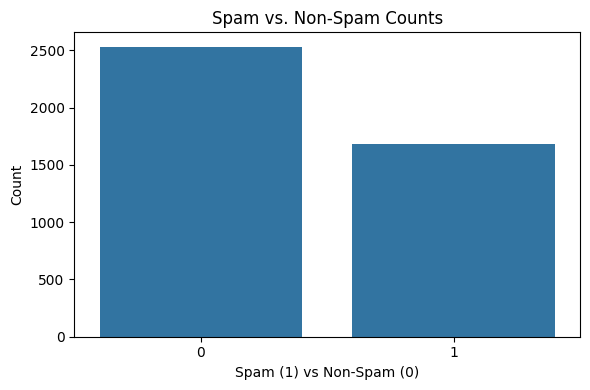

In [18]:
# Distribution of Target Variable
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df_clean)
plt.title("Spam vs. Non-Spam Counts")
plt.xlabel("Spam (1) vs Non-Spam (0)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Feature relevance (mutual information)

To get an initial signal of which predictors are most informative, I compute **mutual information** scores between each feature and the spam label.

This is not a “final” feature selection method, but it helps:
- prioritize variables for visualization
- create a small baseline model for comparison

In [19]:
# identify features with greatest impact on target variable

# Features and target
X = df_clean.drop("Class", axis=1)
y = df_clean["Class"]

# Fit SelectKBest with mutual information
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X, y)

# Create a Series of feature scores
feat_scores = pd.Series(selector.scores_, index=X.columns)

# Get the top 10 features by score, in descending order
top_features = feat_scores.sort_values(ascending=False)

print("Top predictors by mutual information (highest first):")
print(top_features)

Top predictors by mutual information (highest first):
char_freq_!                   0.189347
capital_run_length_longest    0.165629
char_freq_$                   0.165156
capital_run_length_average    0.147767
word_freq_your                0.145184
word_freq_remove              0.135437
word_freq_free                0.132409
word_freq_hp                  0.119064
capital_run_length_total      0.109600
word_freq_money               0.109374
word_freq_you                 0.101152
word_freq_our                 0.090790
word_freq_hpl                 0.090203
word_freq_000                 0.088482
word_freq_george              0.083066
word_freq_over                0.073228
word_freq_all                 0.069065
word_freq_business            0.062156
word_freq_receive             0.060512
word_freq_internet            0.059833
word_freq_1999                0.056990
word_freq_address             0.055023
word_freq_85                  0.053619
word_freq_credit              0.053004
word_freq_

## Distribution checks for top predictors

I plot histograms for the strongest predictors to understand shape and scale.  
Most of these features are highly right-skewed, which motivates later use of `log1p` and standardization.

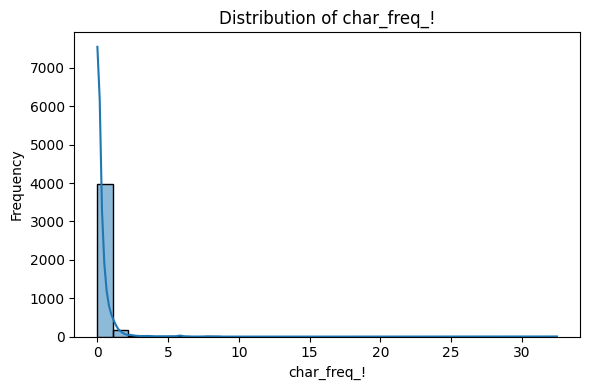

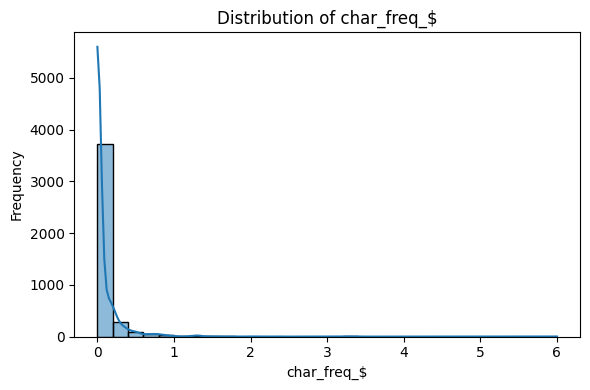

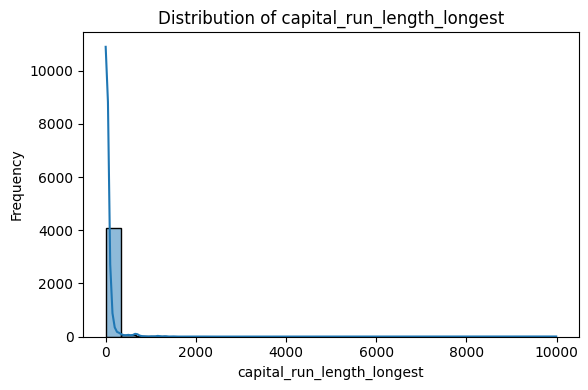

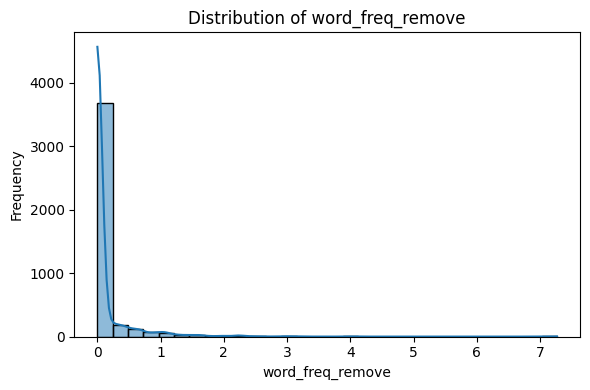

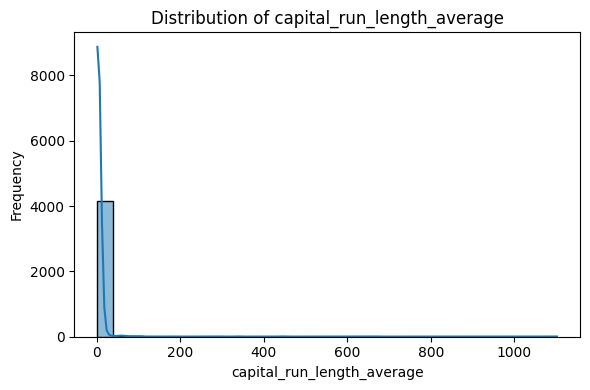

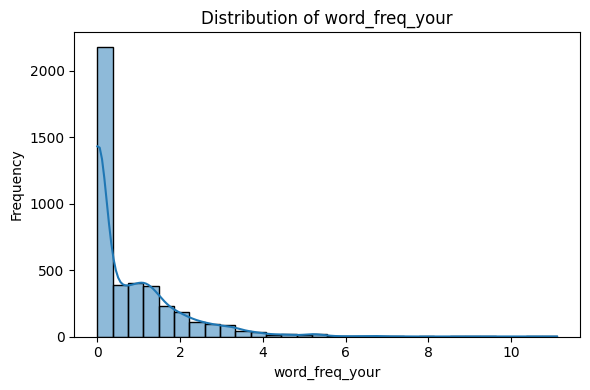

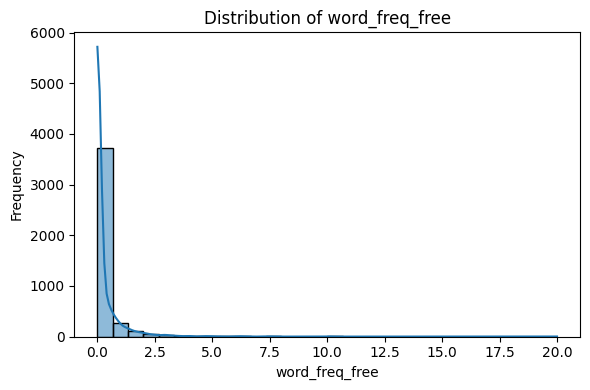

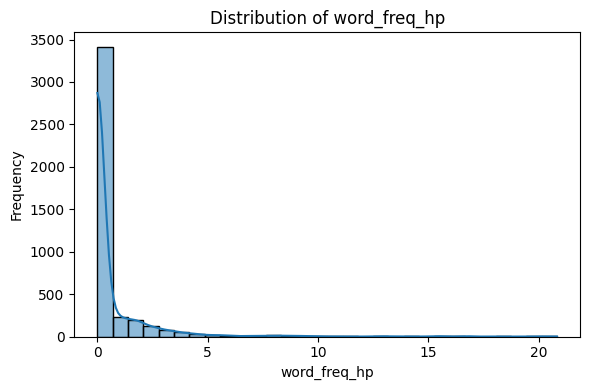

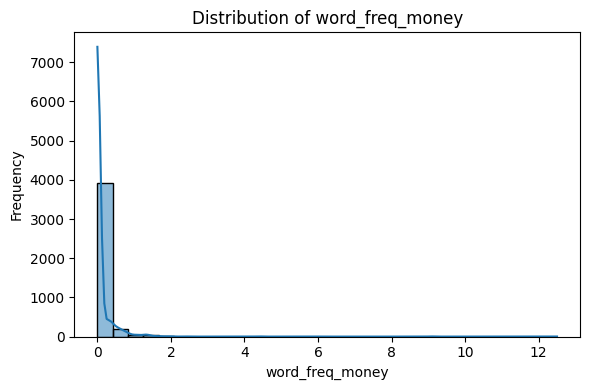

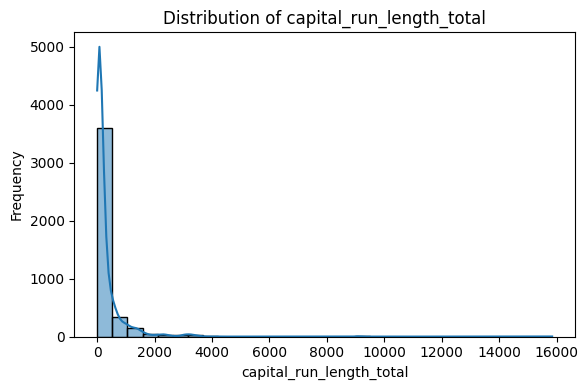

In [20]:
# Histograms of Key Features
key_feats = ['char_freq_!', 'char_freq_$', 'capital_run_length_longest', 'word_freq_remove', 'capital_run_length_average', 'word_freq_your', 'word_freq_free', 'word_freq_hp', 'word_freq_money', 'capital_run_length_total', 
]
for feat in key_feats:
    plt.figure(figsize=(6,4))
    sns.histplot(df_clean[feat], bins=30, kde=True)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

**Observation:** The strongest predictors show heavy right-skew with many zeros and a long tail.  
Next, I test a log transformation (`log1p`) later in the workflow to reduce skew while keeping zeros valid.

## Separation by class

Boxplots help evaluate how well each feature separates spam vs. non-spam.  
I use these to confirm that the mutual information ranking is consistent with visible class separation.

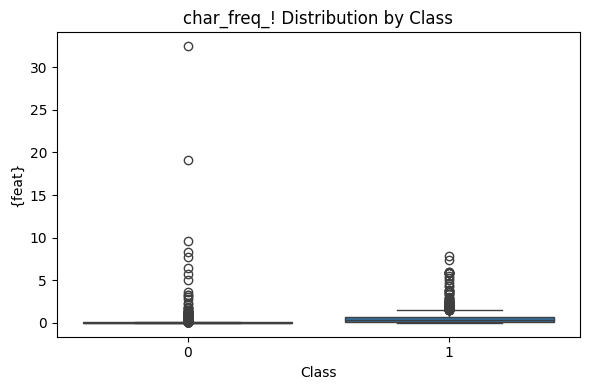

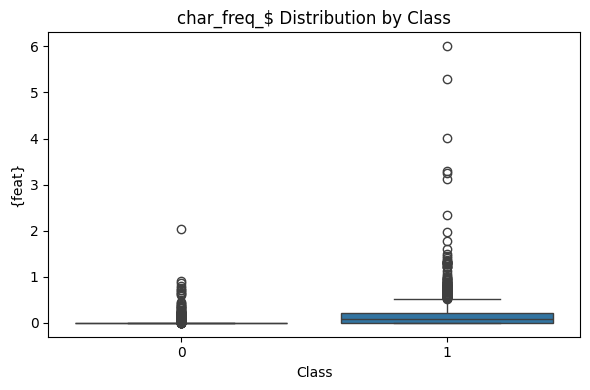

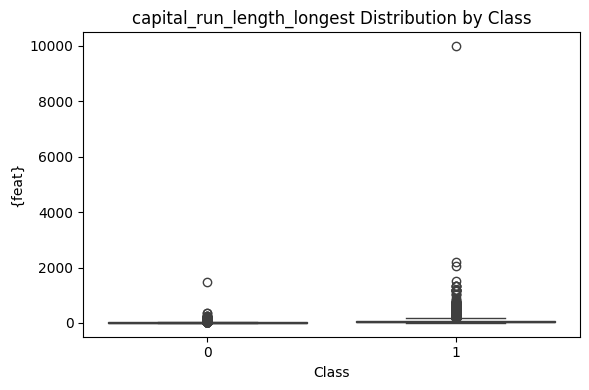

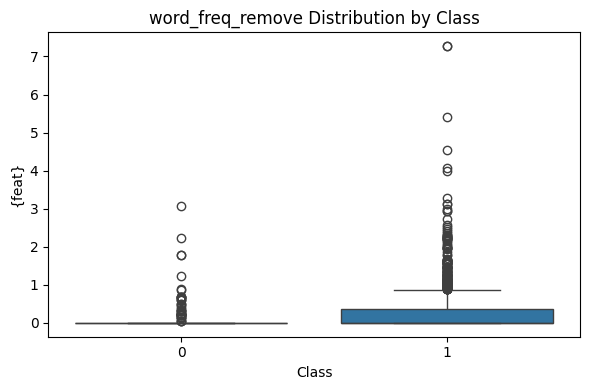

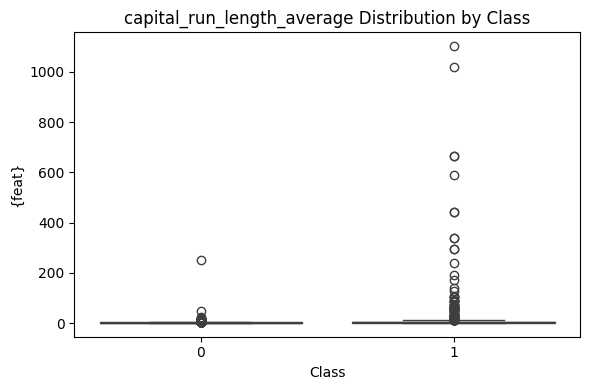

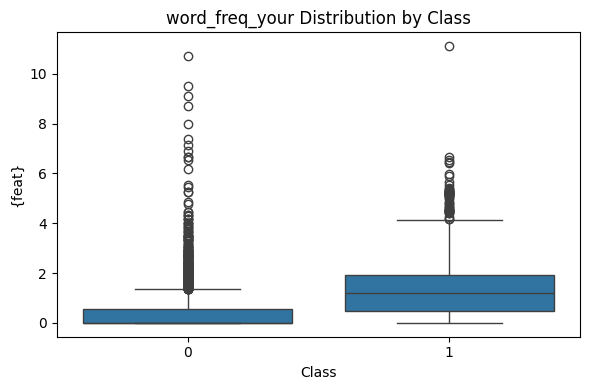

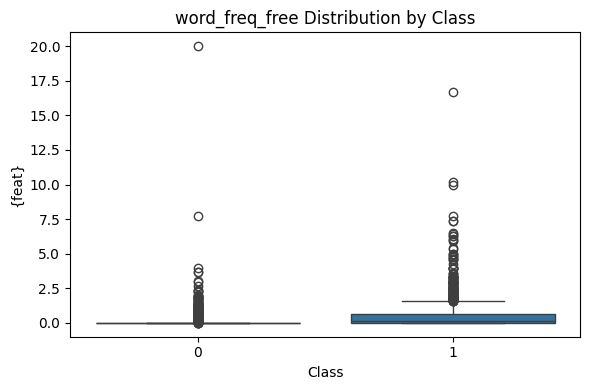

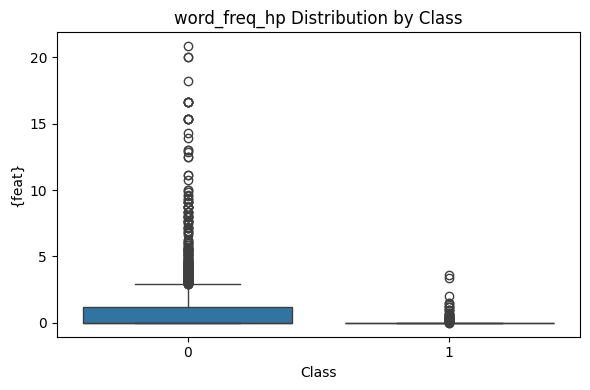

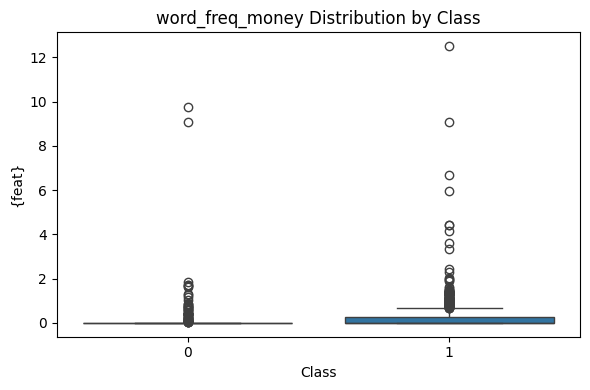

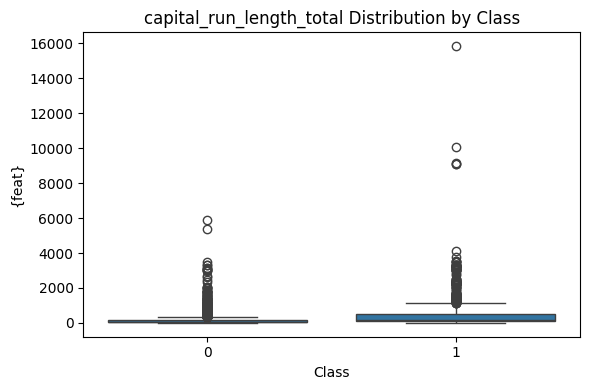

In [21]:
# Boxplots by Class
for feat in key_feats:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Class", y=df_clean[feat], data=df_clean)
    plt.title(f"{feat} Distribution by Class")
    plt.xlabel("Class")
    plt.ylabel("{feat}")
    plt.tight_layout()
    plt.show()

## Correlation scan

Correlation does not capture all forms of multicollinearity, but it is a quick first pass.  
With many variables, I focus the deeper check on the strongest predictors and later compute VIF.

In [22]:
# Correlation plot
df_clean.corr()

word_freq_make  word_freq_address  word_freq_all  \
word_freq_make                    1.000000           0.034012       0.063207   
word_freq_address                 0.034012           1.000000       0.027789   
word_freq_all                     0.063207           0.027789       1.000000   
word_freq_3d                      0.005388          -0.008947      -0.019901   
word_freq_our                     0.021740           0.036975       0.065676   
word_freq_over                    0.055067           0.005526       0.066547   
word_freq_remove                  0.011061           0.077374       0.028581   
word_freq_internet               -0.004370           0.013706       0.007221   
word_freq_order                   0.103842           0.053426       0.077561   
word_freq_mail                    0.040829           0.184304       0.025138   
word_freq_receive                 0.063031           0.060724       0.055647   
word_freq_will                    0.075911           0.026247       0.065733   
word_freq_people                  0.061985           0.015538       0.036431   
word_freq_report                  0.032263           0.012414       0.004900   
word_freq_addresses               0.022454           0.061826       0.104574   
word_freq_free                    0.065443           0.046630       0.061937   
word_freq_business                0.081471           0.022018       0.029834   
word_freq_email                   0.051571           0.178853       0.110794   
word_freq_you                     0.120563           0.055876       0.126502   
word_freq_credit                  0.020924          -0.006735       0.030874   
word_freq_your                    0.121458           0.117797       0.147895   
word_freq_font                   -0.025574           0.001214      -0.039464   
word_freq_000                     0.126478           0.007064       0.106694   
word_freq_money                   0.205689           0.061282       0.031150   
word_freq_hp                     -0.075054          -0.053573      -0.092684   
word_freq_hpl                    -0.063467          -0.044627      -0.066464   
word_freq_george                 -0.048086          -0.011228      -0.081297   
word_freq_650                    -0.050054          -0.033000      -0.051471   
word_freq_lab                    -0.041541          -0.026048      -0.057847   
word_freq_labs                   -0.054241          -0.029419      -0.030519   
word_freq_telnet                 -0.038899          -0.015937      -0.036610   
word_freq_857                    -0.031634           0.028852      -0.063579   
word_freq_data                   -0.042715          -0.032575      -0.058002   
word_freq_415                    -0.026322           0.026039      -0.063417   
word_freq_85                     -0.046083          -0.025524      -0.048968   
word_freq_technology             -0.057296          -0.028262      -0.047593   
word_freq_1999                   -0.058771           0.003749      -0.074329   
word_freq_parts                  -0.008626          -0.012708       0.031756   
word_freq_pm                     -0.011199          -0.016208      -0.017418   
word_freq_direct                 -0.035467           0.002326      -0.046013   
word_freq_cs                     -0.005280          -0.019350      -0.030822   
word_freq_meeting                -0.026546          -0.035908      -0.007620   
word_freq_original               -0.025603           0.037681      -0.052736   
word_freq_project                -0.022980          -0.029055      -0.056883   
word_freq_re                     -0.037848           0.020029      -0.056600   
word_freq_edu                    -0.034455          -0.026004      -0.060558   
word_freq_table                  -0.000950          -0.012337       0.027384   
word_freq_conference             -0.018904          -0.020947      -0.029465   
char_freq_;                      -0.027248           0.014735      -0.036778   
char_freq_(                 

## Correlation heatmap (full feature set)

This view is dense due to 57 predictors, so it’s mainly used to identify any obvious blocks of highly correlated features.

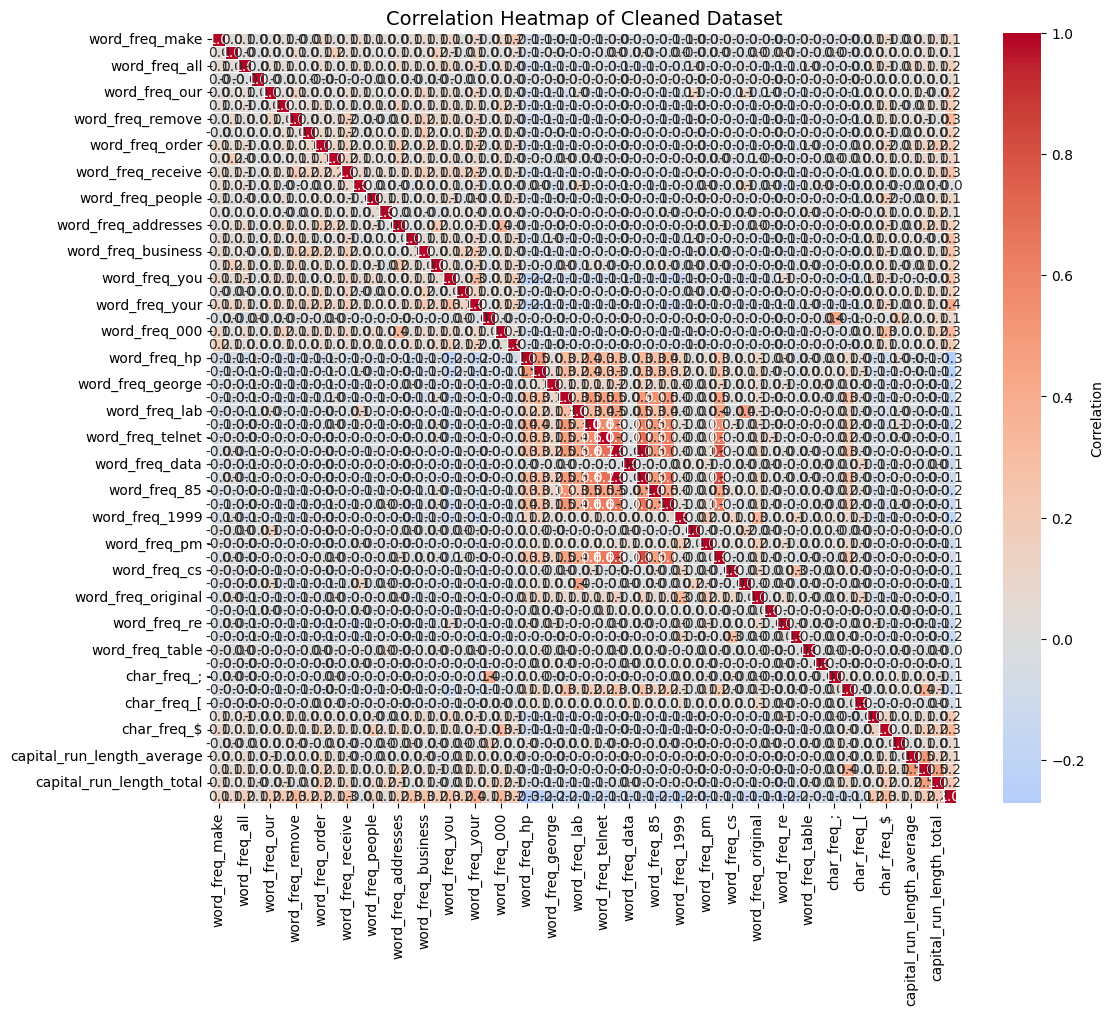

In [23]:
# Correlation Heatmap 

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_clean.corr(),
    cmap="coolwarm",        
    center=0,               
    annot=True,             
    fmt=".1f",              
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)
plt.title("Correlation Heatmap of Cleaned Dataset", fontsize=14)
plt.show()

## Correlation within top predictors

To make the correlation analysis interpretable, I restrict attention to the top 10 predictors and test whether any pair exceeds a high-correlation threshold (0.70).  
This helps determine whether multicollinearity is likely to distort coefficient estimates in the small-feature baseline.

In [24]:
# Create new dataframe with top 10 features and target variable
X = df_clean.drop("Class", axis=1)
y = df_clean["Class"]

# Compute scores for all features
selector = SelectKBest(mutual_info_classif, k='all').fit(X, y)
scores = pd.Series(selector.scores_, index=X.columns)

# Get the top 10 features
top10_features = scores.sort_values(ascending=False).head(10).index.tolist()

# Create a new DataFrame with only those features (and the target)
df_top10 = df_clean[top10_features + ["Class"]]

# Inspect the new DataFrame
print("Top 10 features + target:")
print(df_top10.head())

Top 10 features + target:
   char_freq_!  capital_run_length_longest  char_freq_$  word_freq_remove  \
0        0.778                          61        0.000              0.00   
1        0.372                         101        0.180              0.21   
2        0.276                         485        0.184              0.19   
3        0.137                          40        0.000              0.31   
4        0.135                          40        0.000              0.31   

   capital_run_length_average  word_freq_your  word_freq_free  word_freq_hp  \
0                       3.756            0.96            0.32           0.0   
1                       5.114            1.59            0.14           0.0   
2                       9.821            0.51            0.06           0.0   
3                       3.537            0.31            0.31           0.0   
4                       3.537            0.31            0.31           0.0   

   word_freq_money  capital_run_leng

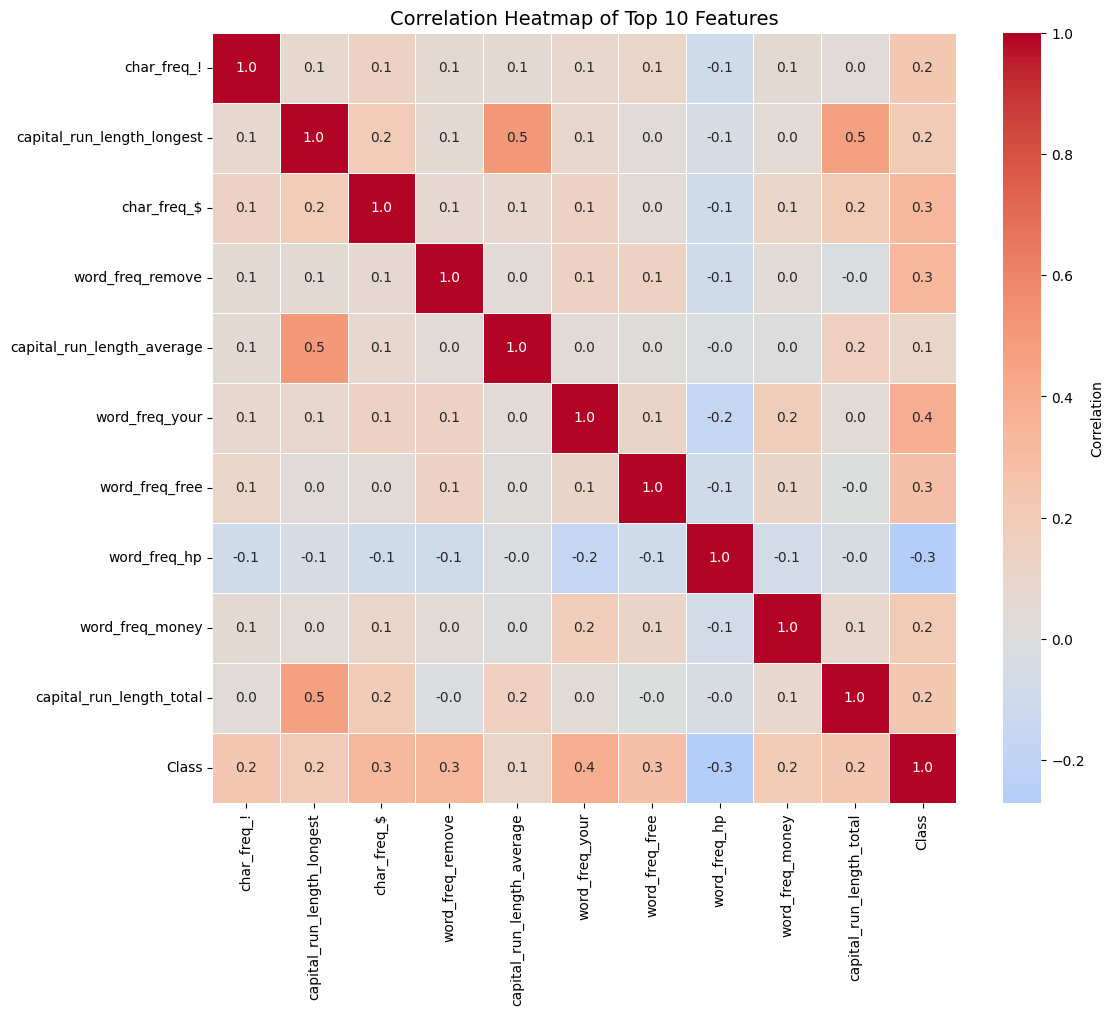

In [25]:
# Correlation Heatmap of Top 10 Features

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_top10.corr(),
    cmap="coolwarm",        
    center=0,               
    annot=True,             
    fmt=".1f",              
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)
plt.title("Correlation Heatmap of Top 10 Features", fontsize=14)
plt.show()

In [26]:
# Create absolute correlation matrix
corr = df_top10.corr().abs()
corr

char_freq_!  capital_run_length_longest  \
char_freq_!                    1.000000                    0.072619   
capital_run_length_longest     0.072619                    1.000000   
char_freq_$                    0.136701                    0.188864   
word_freq_remove               0.050992                    0.050825   
capital_run_length_average     0.052682                    0.499447   
word_freq_your                 0.087063                    0.087475   
word_freq_free                 0.108318                    0.025523   
word_freq_hp                   0.095756                    0.051517   
word_freq_money                0.050250                    0.044175   
capital_run_length_total       0.025249                    0.464514   
Class                          0.233812                    0.203657   

                            char_freq_$  word_freq_remove  \
char_freq_!                    0.136701          0.050992   
capital_run_length_longest     0.188864          0.050825   
char_freq_$                    1.000000          0.067236   
word_freq_remove               0.067236          1.000000   
capital_run_length_average     0.083635          0.039174   
word_freq_your                 0.149502          0.143770   
word_freq_free                 0.044005          0.135875   
word_freq_hp                   0.092656          0.094994   
word_freq_money                0.103525          0.034547   
capital_run_length_total       0.205982          0.017081   
Class                          0.326603          0.334456   

                            capital_run_length_average  word_freq_your  \
char_freq_!                                   0.052682        0.087063   
capital_run_length_longest                    0.499447        0.087475   
char_freq_$                                   0.083635        0.149502   
word_freq_remove                              0.039174        0.143770   
capital_run_length_average                    1.000000        0.041029   
word_freq_your                                0.041029        1.000000   
word_freq_free                                0.014830        0.114528   
word_freq_hp                                  0.019044        0.165462   
word_freq_money                               0.007632        0.171995   
capital_run_length_total                      0.162626        0.047364   
Class                                         0.110274        0.394392   

                            word_freq_free  word_freq_hp  word_freq_money  \
char_freq_!                       0.108318      0.095756         0.050250   
capital_run_length_longest        0.025523      0.051517         0.044175   
char_freq_$                       0.044005      0.092656         0.103525   
word_freq_remove                  0.135875      0.094994         0.034547   
capital_run_length_average        0.014830      0.019044         0.007632   
word_freq_your                    0.114528      0.165462         0.171995   
word_freq_free                    1.000000      0.099130         0.112255   
word_freq_hp                      0.099130      1.000000         0.069116   
word_freq_money                   0.112255      0.069116         1.000000   
capital_run_length_total          0.003013      0.045403         0.081323   
Class                             0.279261      0.270024         0.205045   

                            capital_run_length_total     Class  
char_freq_!                                 0.025249  0.233812  
capital_run_length_longest                  0.464514  0.203657  
char_freq_$                                 0.205982  0.326603  
word_freq_remove                            0.017081  0.334456  
capital_run_length_average                  0.162626  0.110274  
word_freq_your                              0.047364  0.394392  
word_freq_free                              0.003013  0.279261  
word_freq_hp                                0.045403  0.270024  
word_freq_money                            

In [27]:
# set threshold for high correlation
threshold = 0.70

In [28]:
# Find all variable pairs with correlation >= threshold
high_corr_pairs = [
    (f1, f2, corr.at[f1, f2])
    for f1, f2 in combinations(corr.columns, 2)
    if corr.at[f1, f2] > threshold
]

# Sort by descending correlation
high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)

# Display results
df_high_corr = pd.DataFrame(high_corr_pairs_sorted, columns=['Feature 1', 'Feature 2', 'Correlation'])
print(df_high_corr)

Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []


The top 10 features are under the threshold for correlation; multicollinearity not present in this subset. 

#### Pairplots

## Pairwise relationships (top predictors)

Pairplots provide a quick visual check for:
- clustering by class
- nonlinear relationships
- strong feature-feature correlations that may not be obvious from summary stats

In [29]:
# Create colorblind-safe palette for use in visualizations
accessible_palette = {
    0: "#0072B2",  # Non-defaulters (Blue)
    1: "#D55E00"   # Defaulters (Red-Orange)
}

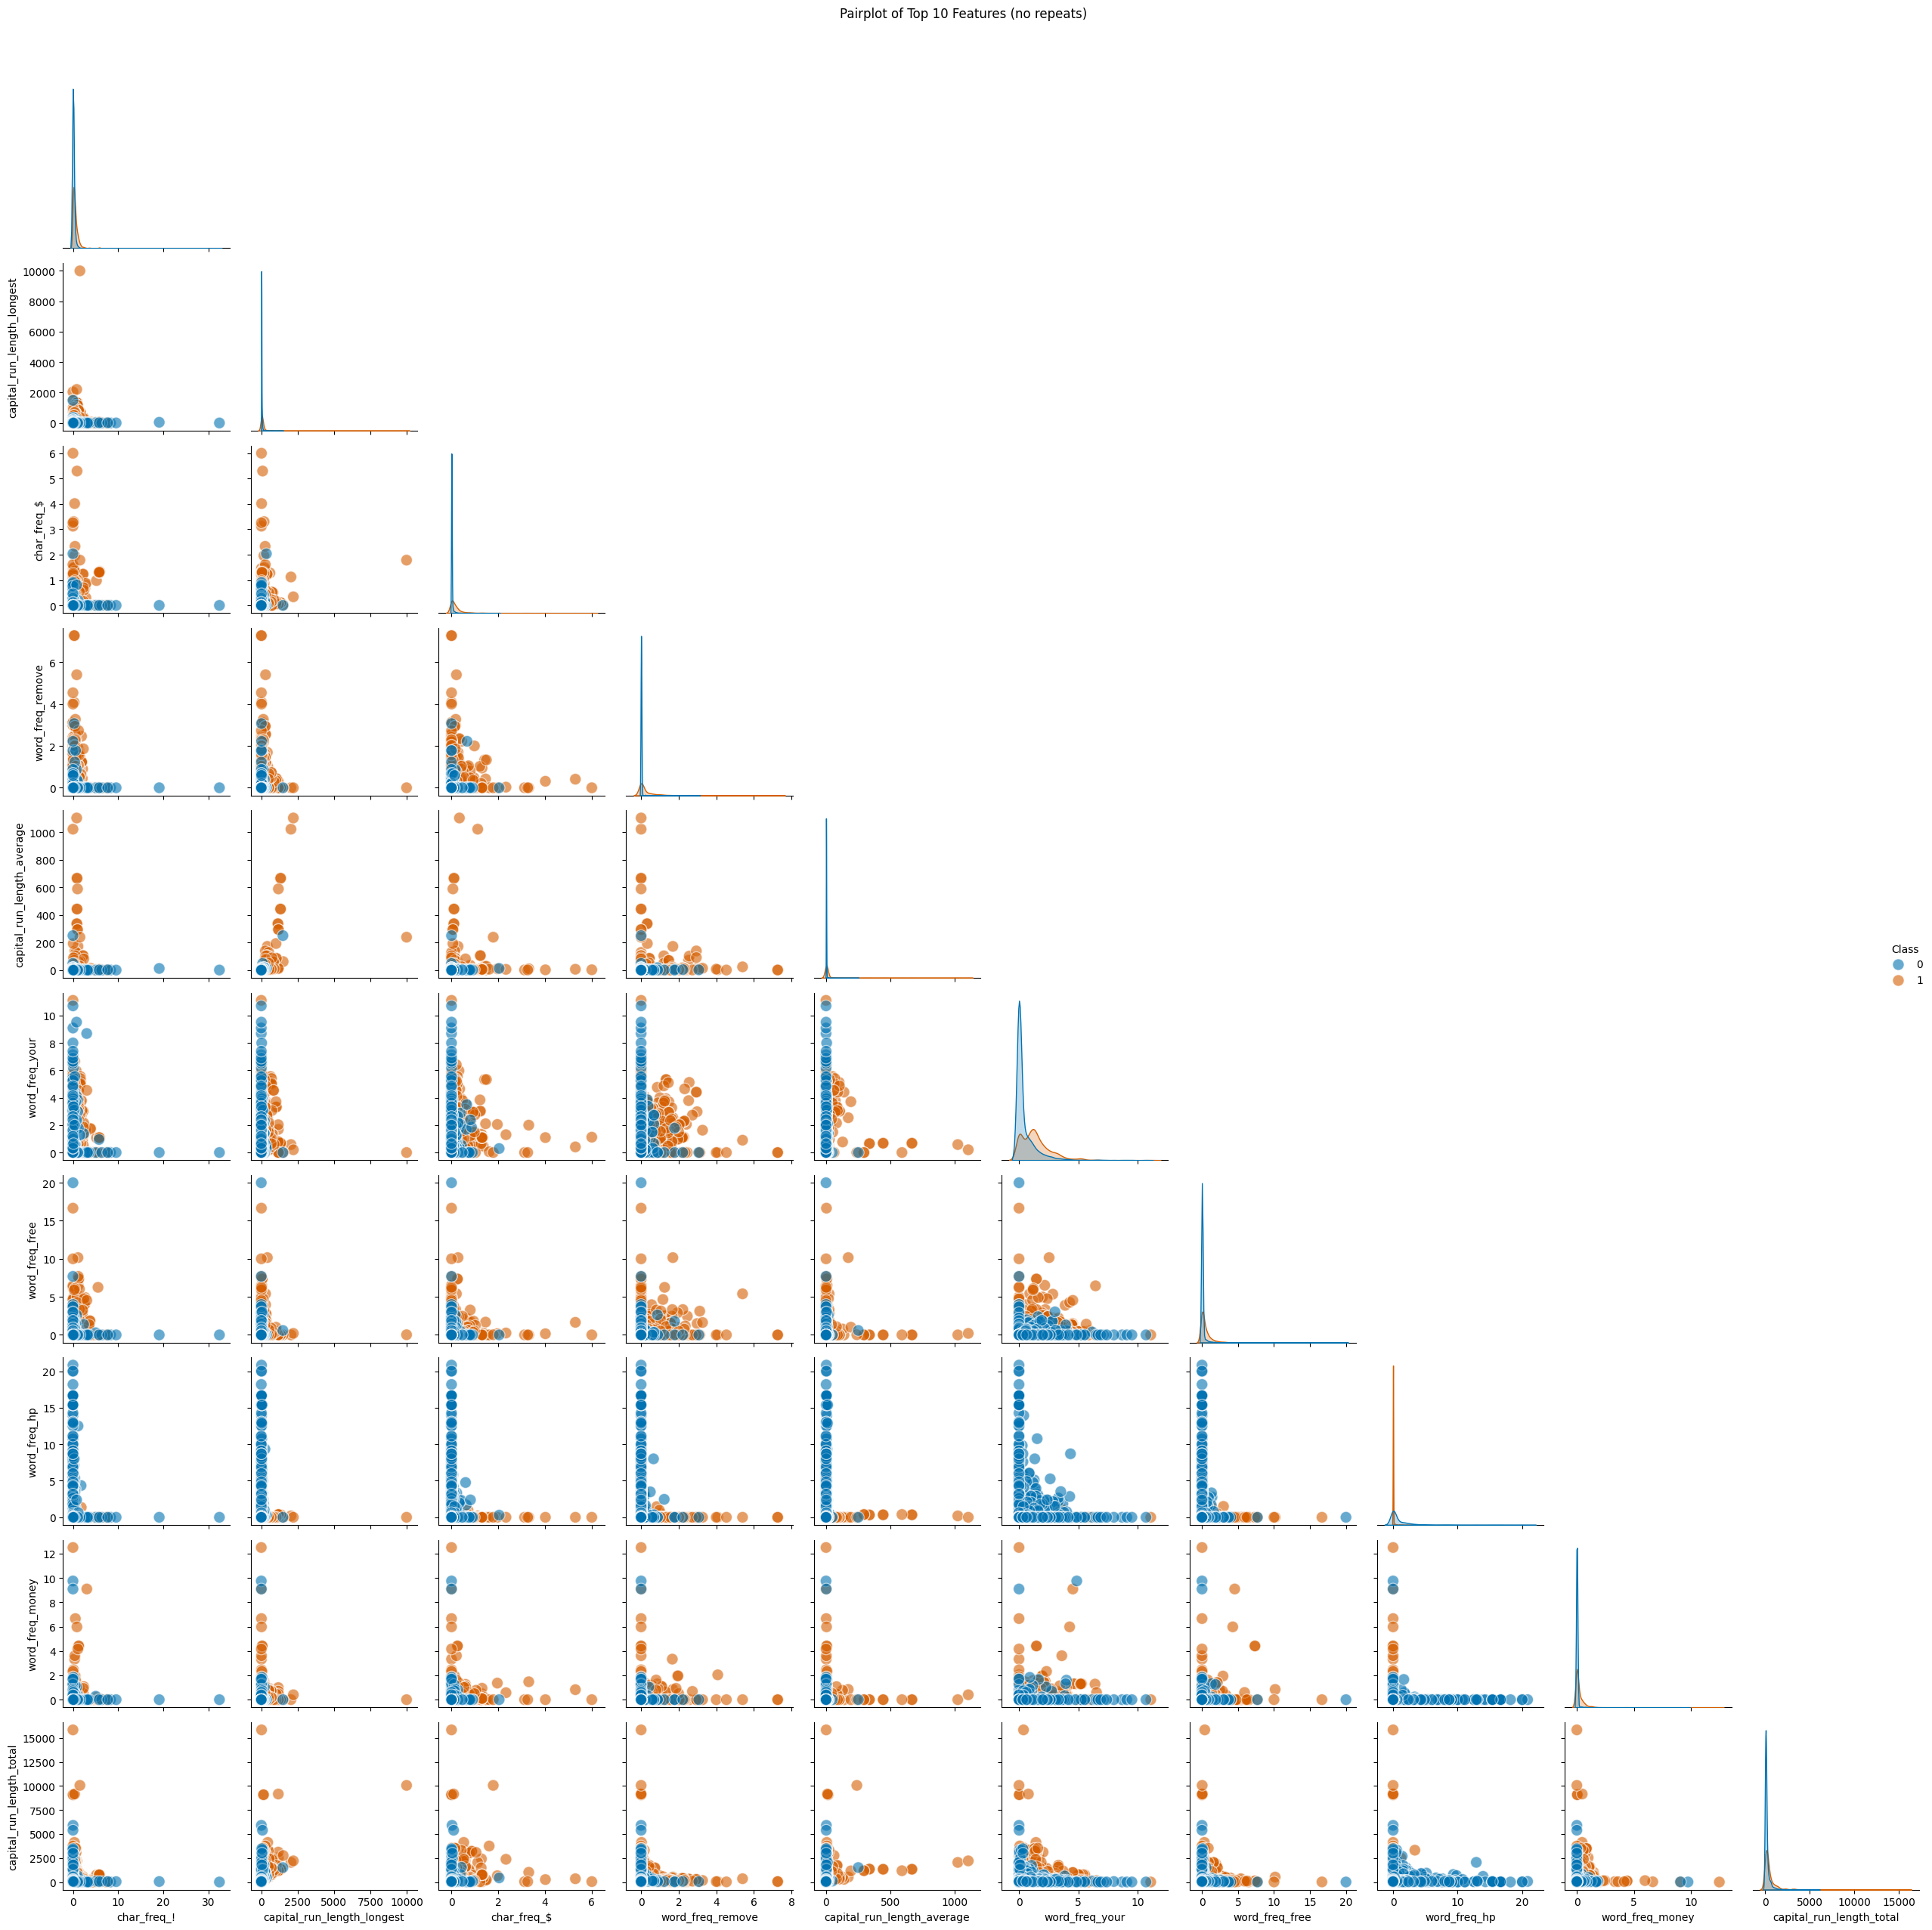

In [30]:
# Pairplot of selected features

sns.pairplot(
    df_clean[top10_features + ['Class']],
    vars=top10_features,
    hue='Class',
    palette=accessible_palette,
    corner=True,            # only lower triangle + diagonal
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 120}
)
plt.suptitle("Pairplot of Top 10 Features (no repeats)", y=1.02)
plt.tight_layout()
plt.show()

Notes
-  spam messages tend to have higher counts of the following features: 'word_freq_your', 'word_freq_remove','word_freq_free', 'char_freq_$', and 'capital_run_length_total'
-  

## Targeted scatterplots

I plot a few feature pairs that appear most relevant to spam behavior (e.g., “remove”, “free”, currency symbols, and capitalization intensity).  
These plots help explain *why* certain features rank highly and how they interact.

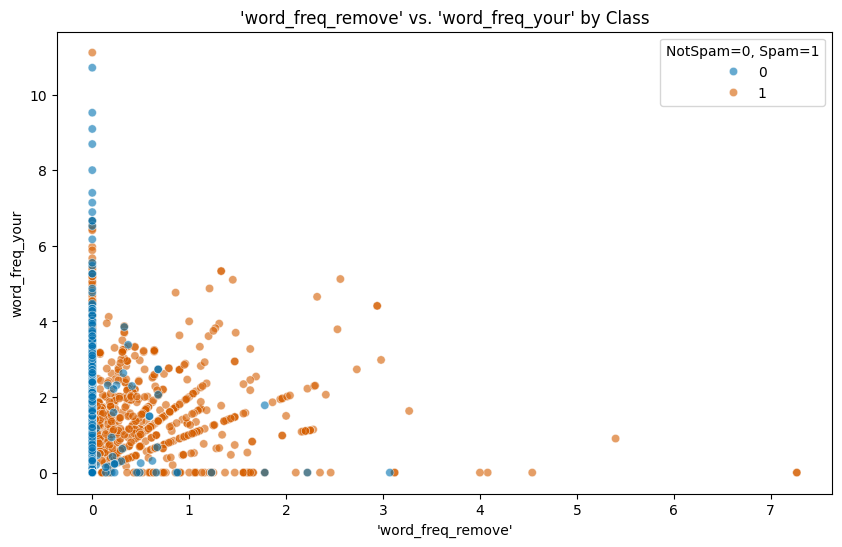

In [31]:
# Scatter plot: 'word_freq_remove' vs. 'word_freq_your' by Class
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_freq_remove', y='word_freq_your', hue='Class', palette=accessible_palette, data=df_top10, alpha=0.6)
plt.title("'word_freq_remove' vs. 'word_freq_your' by Class")
plt.xlabel("'word_freq_remove'")
plt.ylabel("word_freq_your")
plt.legend(title="NotSpam=0, Spam=1")
plt.show()

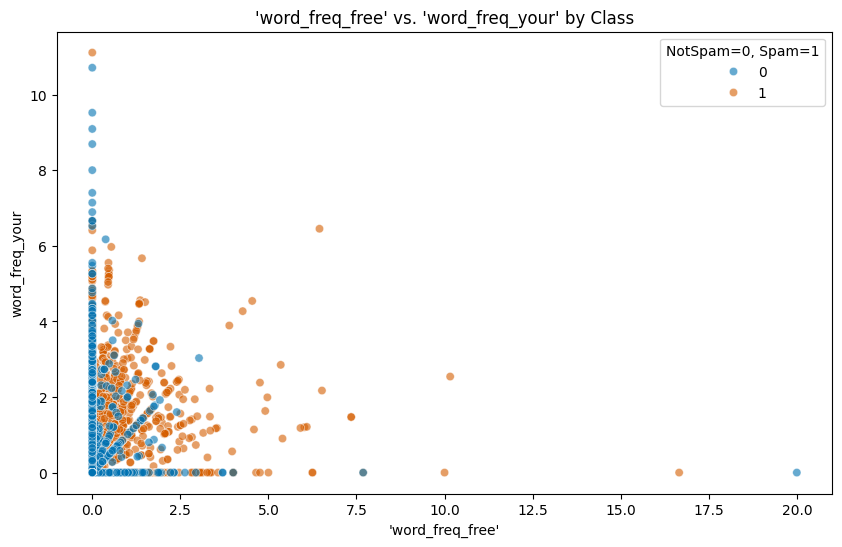

In [32]:
# Scatter plot: 'word_freq_free' vs. 'word_freq_your' by Class
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_freq_free', y='word_freq_your', hue='Class', palette=accessible_palette, data=df_top10, alpha=0.6)
plt.title("'word_freq_free' vs. 'word_freq_your' by Class")
plt.xlabel("'word_freq_free'")
plt.ylabel("word_freq_your")
plt.legend(title="NotSpam=0, Spam=1")
plt.show()

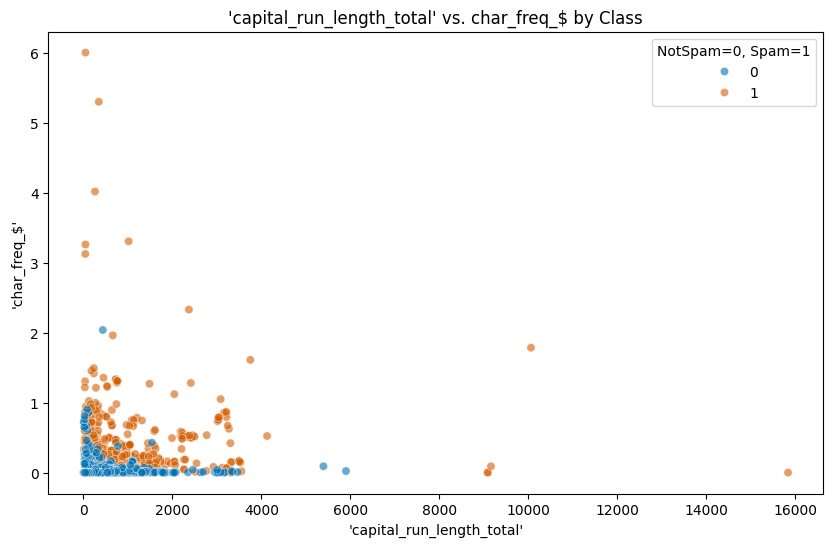

In [33]:
# Scatter plot: 'capital_run_length_total' vs. 'char_freq_$' by Class
plt.figure(figsize=(10, 6))
sns.scatterplot(x='capital_run_length_total', y='char_freq_$', hue='Class', palette=accessible_palette, data=df_top10, alpha=0.6)
plt.title("'capital_run_length_total' vs. char_freq_$ by Class")
plt.xlabel("'capital_run_length_total'")
plt.ylabel("'char_freq_$'")
plt.legend(title="NotSpam=0, Spam=1")
plt.show()

Spam emails associated with longer capital_run_length_totals, higher counts of character "$"

## Statistical comparison of feature distributions

To quantify how strongly each top feature differs between spam and non-spam, I compute:
- mean differences by class
- a Kolmogorov–Smirnov (KS) test for distributional separation

This supports the EDA findings with a formal comparison.

In [34]:
for feat in top10_features:
    spam = df[df["Class"]==1][feat]
    nonspam = df[df["Class"]==0][feat]
    print(f"\nFeature: {feat}")
    print(f"  Mean (spam)    = {spam.mean():.3f}")
    print(f"  Mean (nonspam) = {nonspam.mean():.3f}")
    ks_stat, p = ks_2samp(spam, nonspam)
    print(f"  KS-test: statistic={ks_stat:.3f}, p-value={p:.3e}")


Feature: char_freq_!
  Mean (spam)    = 0.514
  Mean (nonspam) = 0.110
  KS-test: statistic=0.575, p-value=2.297e-321

Feature: capital_run_length_longest
  Mean (spam)    = 104.393
  Mean (nonspam) = 18.214
  KS-test: statistic=0.460, p-value=4.269e-210

Feature: char_freq_$
  Mean (spam)    = 0.174
  Mean (nonspam) = 0.012
  KS-test: statistic=0.516, p-value=1.079e-267

Feature: word_freq_remove
  Mean (spam)    = 0.275
  Mean (nonspam) = 0.009
  KS-test: statistic=0.406, p-value=1.590e-162

Feature: capital_run_length_average
  Mean (spam)    = 9.519
  Mean (nonspam) = 2.377
  KS-test: statistic=0.447, p-value=5.862e-198

Feature: word_freq_your
  Mean (spam)    = 1.380
  Mean (nonspam) = 0.439
  KS-test: statistic=0.507, p-value=4.495e-258

Feature: word_freq_free
  Mean (spam)    = 0.518
  Mean (nonspam) = 0.074
  KS-test: statistic=0.456, p-value=5.843e-207

Feature: word_freq_hp
  Mean (spam)    = 0.017
  Mean (nonspam) = 0.895
  KS-test: statistic=0.350, p-value=6.443e-120

Fe

Notes
-  Mean differences indicate which class (spam/not spam) tends to have higher values
-  The Kolmogorov-Smirnov test indicates that spam/not spam differs significantly on the top 10 feature distributions at p <0.0001

# Baseline model (top 10 features)

I fit a logistic regression model using the top 10 predictors as a compact baseline.

Steps:
- stratified train/test split to preserve class proportions
- standardization to place predictors on comparable scales
- logistic regression without regularization as a reference point

In [35]:
# Create the model using top10 features dataset, then create confusion matrix

# split features/target
X = df_top10.drop("Class", axis=1)
y = df_top10["Class"]

In [36]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [37]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [38]:
# Fit logistic regression without regularization (control)
model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, penalty=None, random_state=42)

## Baseline performance summary

- **Precision (spam = 1):** When the model flags an email as spam, it is correct most of the time (low false-positive rate).
- **Recall (spam = 1):** The model catches a majority of spam but still misses a meaningful portion (false negatives).
- **ROC-AUC:** Strong ranking ability, suggesting good separation even when the classification threshold changes.

Because false positives are costly in spam filtering, I prioritize precision and AUC throughout the comparisons.

In [39]:
# Evaluate model performance
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       759
           1       0.89      0.79      0.84       504

    accuracy                           0.88      1263
   macro avg       0.88      0.86      0.87      1263
weighted avg       0.88      0.88      0.88      1263

ROC AUC: 0.939


## ROC curve

The ROC curve visualizes the tradeoff between true-positive and false-positive rates across thresholds.  
This is useful because spam filtering decisions can be tuned depending on tolerance for false positives.

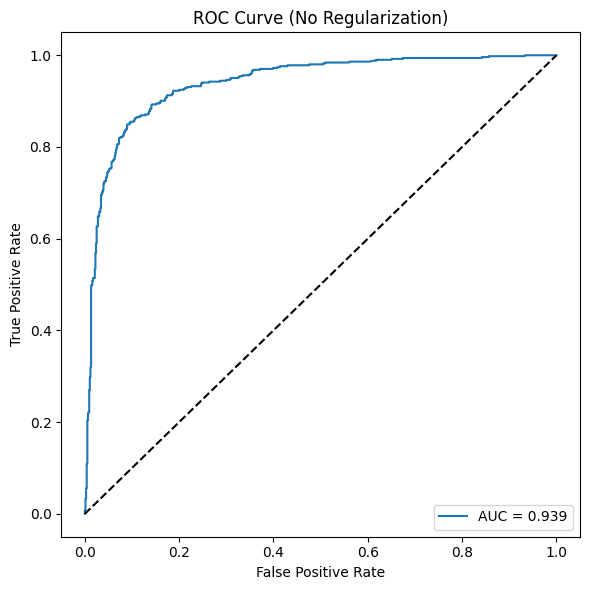

In [40]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (No Regularization)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Regularization and tuning (top 10 features)

I compare:
- **L2 regularization** (shrinks coefficients smoothly)
- **L1 regularization** (encourages sparsity / implicit feature selection)

I then use cross-validated grid search over `C` (regularization strength) and penalty type, optimizing ROC-AUC.

In [41]:
# Create the model using top10 features dataset + regularization

# split features/target
X = df_top10.drop("Class", axis=1)
y = df_top10["Class"]

In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [43]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [44]:
# Fit model with default L2 regularization
lr_l2 = LogisticRegression(penalty="l2", solver="liblinear", C=1.0, random_state=42)
lr_l2.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [45]:
# Fit with L1 regularization (sparse coefficients)
lr_l1 = LogisticRegression(penalty="l1", solver="liblinear", C=1.0, random_state=42)
lr_l1.fit(X_train_scaled, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [46]:
# Hyperparameter tuning: search over C and penalty type
param_grid = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-3, 3, 7)
}
grid = GridSearchCV(
    LogisticRegression(solver="liblinear", random_state=42),
    param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)
grid.fit(X_train_scaled, y_train)
best = grid.best_estimator_

## Interpreting coefficients

Examining coefficient magnitudes helps explain what the model learns.  
In this dataset, some features are strong negative indicators of spam (e.g., signals tied to personal/work email), while others strongly increase spam probability (e.g., currency symbols and capitalization patterns).

In [47]:
# Examine coefficients
coef_df = pd.DataFrame({
    "L2 (C=1)": lr_l2.coef_[0],
    "L1 (C=1)": lr_l1.coef_[0],
    f"Best ({grid.best_params_})": best.coef_[0]
}, index=X.columns)
print("Top 10 absolute coefficients in best model:")
print(coef_df[f"Best ({grid.best_params_})"].abs().sort_values(ascending=False).head(10))

Top 10 absolute coefficients in best model:
word_freq_hp                  5.574517
char_freq_$                   2.258275
capital_run_length_longest    2.165742
word_freq_remove              1.659864
word_freq_free                0.731871
capital_run_length_total      0.624413
char_freq_!                   0.582660
word_freq_your                0.399431
word_freq_money               0.317670
capital_run_length_average    0.068938
Name: Best ({'C': np.float64(1000.0), 'penalty': 'l2'}), dtype: float64


In [48]:
# Test accuracy
print(f"\nBest model test accuracy: {best.score(X_test_scaled, y_test):.3f}")


Best model test accuracy: 0.877


# Model comparison

To compare approaches consistently, I evaluate four configurations:
1. Top 10 features, no regularization  
2. Top 10 features, L2 regularization  
3. All features, no regularization  
4. All features, L2 regularization  

This makes it clear whether performance gains come from feature count, regularization, or both.

In [49]:
# create function that fits model with or without regularization

def train_and_evaluate(df, regularize):
    # Split features/target
    X = df.drop("Class", axis=1)
    y = df["Class"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # Choose and fit model
    if regularize:
        model = LogisticRegression(
            penalty='l2', solver='liblinear', C=1.0, random_state=42
        )
    else:
        model = LogisticRegression(
            penalty=None, solver='lbfgs', max_iter=1000, random_state=42
        )
    model.fit(X_train_scaled, y_train)
    
    # Make predictions & evaluate model
    y_pred  = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n=== {'With' if regularize else 'No'} Regularization | Features: {X.shape[1]} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")


## Interpreting results

- **Top 10 vs. all features:** Using all 57 predictors improves accuracy and ROC-AUC, suggesting additional features provide incremental signal.
- **Regularization:** With a strong signal and sufficient data, L2 regularization changes performance only slightly, but it can improve stability and reduce overfitting risk.

Because false positives are costly, I treat precision as especially important when choosing a final model.

In [50]:
# Run all 4 models
# Model 1: Top 10 features, no regularization
train_and_evaluate(df_top10, regularize=False)

# Model 2: Top 10 features, with L2 regularization
train_and_evaluate(df_top10, regularize=True)

# Model 3: All features, no regularization
train_and_evaluate(df_clean, regularize=False)

# Model 4: All features, with L2 regularization
train_and_evaluate(df_clean, regularize=True)


=== No Regularization | Features: 10 ===
              precision    recall  f1-score   support

           0      0.872     0.933     0.901       759
           1      0.887     0.794     0.838       504

    accuracy                          0.877      1263
   macro avg      0.879     0.863     0.870      1263
weighted avg      0.878     0.877     0.876      1263

ROC AUC: 0.939

=== With Regularization | Features: 10 ===
              precision    recall  f1-score   support

           0      0.869     0.933     0.900       759
           1      0.886     0.788     0.834       504

    accuracy                          0.875      1263
   macro avg      0.877     0.860     0.867      1263
weighted avg      0.876     0.875     0.873      1263

ROC AUC: 0.939

=== No Regularization | Features: 57 ===
              precision    recall  f1-score   support

           0      0.931     0.949     0.940       759
           1      0.920     0.895     0.907       504

    accuracy            

# Addressing skew with log transformation

Many predictors are extremely right-skewed.  
I apply `log1p` (log(1 + x)) to:
- reduce the influence of large outliers
- keep zeros valid (common in frequency features)
- improve linear model fit and coefficient stability

I confirm the effect by comparing skewness before vs. after transformation.

In [51]:
# Identify feature columns (exclude the target 'Class'):
feature_cols = [c for c in df_clean.columns if c != "Class"]

# Check skew before:
skew_before = df_clean[feature_cols].skew().sort_values(ascending=False)
print("Most skewed before:\n", skew_before.head(10))


Most skewed before:
 char_freq_#                   31.500180
capital_run_length_longest    31.205495
word_freq_3d                  27.209539
word_freq_parts               27.078694
capital_run_length_average    22.760655
char_freq_[                   21.271982
word_freq_table               19.298485
word_freq_conference          18.871757
char_freq_!                   18.337278
word_freq_project             18.196824
dtype: float64


# Models with transformed features

After transformation, I rerun the same model comparisons to see whether reducing skew improves:
- recall (catching more spam)
- generalization (AUC / overall performance)


In [52]:
# Create new dataframe with log1p transformed features
df_log = df_clean.copy()
df_log[feature_cols] = np.log1p(df_clean[feature_cols])

# Check skew after:
skew_after = df_log[feature_cols].skew().sort_values(ascending=False)
print("\nMost skewed after:\n", skew_after.head(10))


Most skewed after:
 word_freq_3d            18.564144
word_freq_parts         17.293570
word_freq_table         15.931818
char_freq_[             10.573006
char_freq_#             10.464002
word_freq_conference     9.064007
char_freq_;              8.970024
word_freq_cs             7.858219
word_freq_font           7.757375
word_freq_857            7.201389
dtype: float64


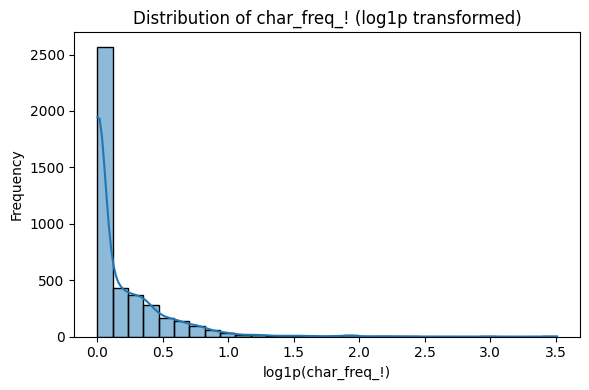

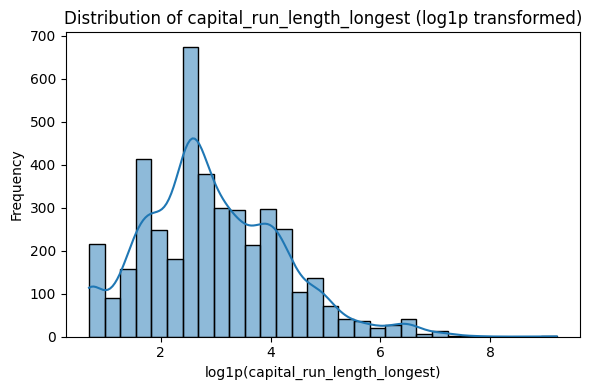

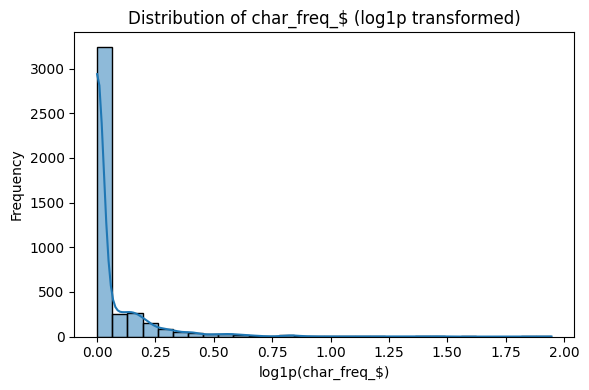

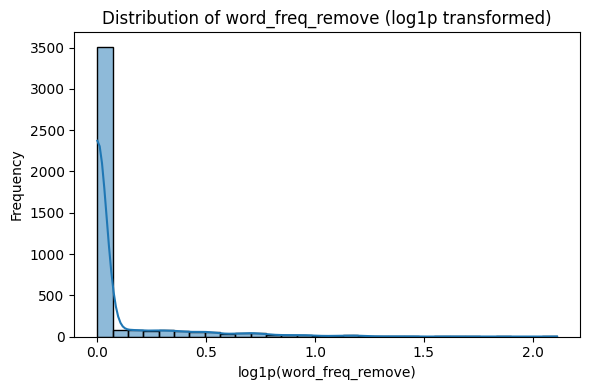

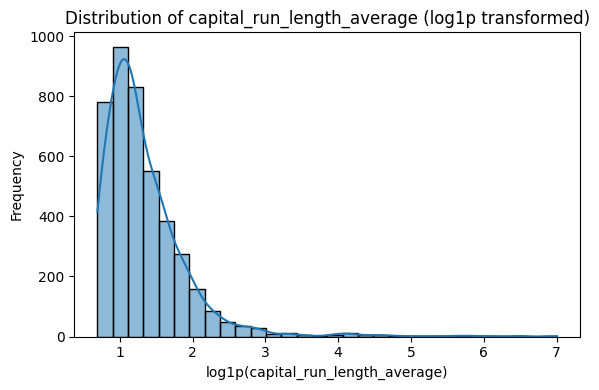

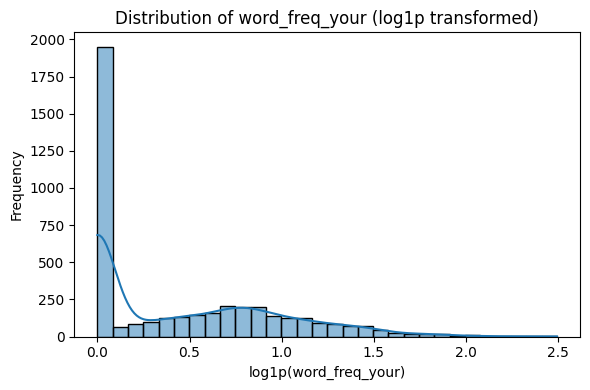

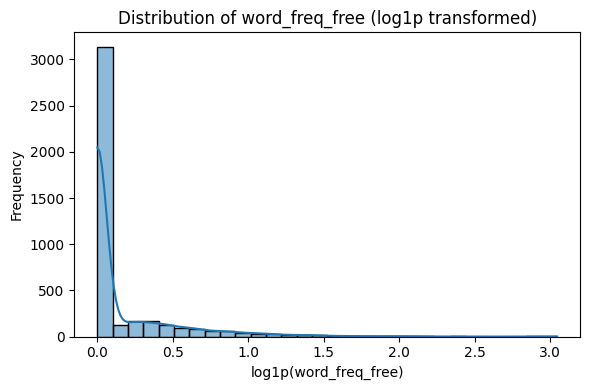

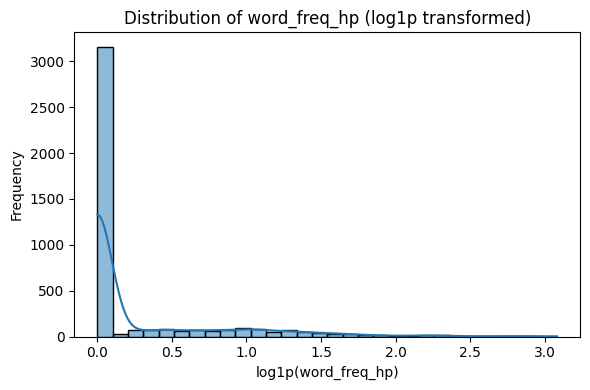

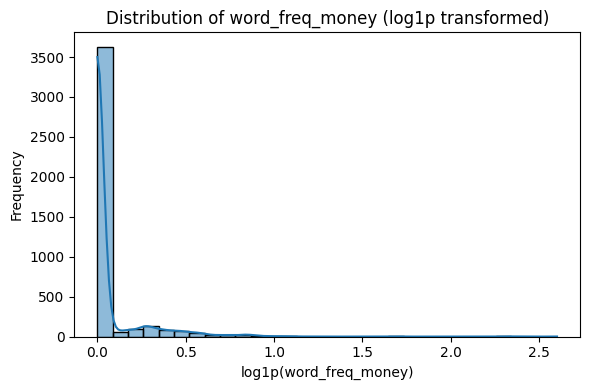

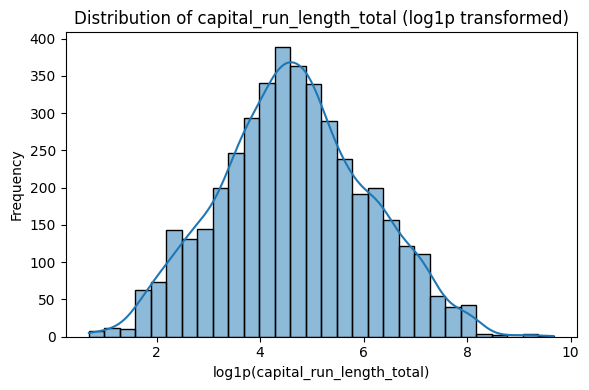

In [53]:
for feat in top10_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_log[feat], bins=30, kde=True)
    plt.title(f"Distribution of {feat} (log1p transformed)")
    plt.xlabel(f"log1p({feat})")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [54]:
# Select top 10 features on transformed data
X_log = df_log[feature_cols]
y_log = df_log['Class']
selector = SelectKBest(mutual_info_classif, k=10).fit(X_log, y_log)
top10_features = X_log.columns[selector.get_support()].tolist()

In [55]:
# Prepare DataFrames
df_top10_log = df_log[top10_features + ['Class']]
df_all_log   = df_log.copy()

In [56]:
# Define train/evaluate function
def train_and_evaluate(df, regularize):
    X = df.drop('Class', axis=1)
    y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    if regularize:
        model = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42)
    else:
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred  = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    print(f"\n=== {'With' if regularize else 'No'} Reg | Features: {X.shape[1]} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

In [57]:
# Run the four models
# Model 1: Top 10, no regularization
train_and_evaluate(df_top10_log, regularize=False)

# Model 2: Top 10, with regularization
train_and_evaluate(df_top10_log, regularize=True)

# Model 3: All 57, no regularization
train_and_evaluate(df_all_log, regularize=False)

# Model 4: All 57, with regularization
train_and_evaluate(df_all_log, regularize=True)


=== No Reg | Features: 10 ===
              precision    recall  f1-score   support

           0      0.904     0.922     0.913       759
           1      0.879     0.853     0.866       504

    accuracy                          0.895      1263
   macro avg      0.892     0.888     0.890      1263
weighted avg      0.894     0.895     0.894      1263

ROC AUC: 0.950

=== With Reg | Features: 10 ===
              precision    recall  f1-score   support

           0      0.904     0.922     0.913       759
           1      0.879     0.853     0.866       504

    accuracy                          0.895      1263
   macro avg      0.892     0.888     0.890      1263
weighted avg      0.894     0.895     0.894      1263

ROC AUC: 0.950

=== No Reg | Features: 57 ===
              precision    recall  f1-score   support

           0      0.946     0.947     0.947       759
           1      0.920     0.919     0.920       504

    accuracy                          0.936      1263
   

## Effect of transformation

`log1p` improves performance across model variants, especially recall for the reduced-feature models.  
This indicates that heavy skew and extreme values were limiting model fit prior to transformation.

# Logistic regression diagnostics (assumptions)

I validate several practical assumptions:
1. Adequate sample size for stable estimation  
2. Linearity in the logit (checked visually)  
3. Multicollinearity (VIF)  
4. Outlier influence (handled via transformation + scaling)  
5. Independence of errors (approximate check via residual diagnostics)

## Statsmodels version for diagnostics

`statsmodels` provides coefficient standard errors, significance tests, and diagnostics that are useful for interpretation.  
Because some feature names contain special characters, I sanitize column names before building the formula.

In [58]:
# Use Patsy, which mimics R, to save yourself the headache of manually building arrays 
# Make a “safe” copy of df_clean (patsy doesn't like characters)
df_safe = df_clean.copy()

# Create a mapping from old to safe names
safe_names = {
    col: re.sub(r'[^0-9a-zA-Z]+', '_', col).strip('_')
    for col in df_safe.columns
}
df_safe.rename(columns=safe_names, inplace=True)

# Build and fit the full model
# target = safe_names['Class'] if even 'Class' got changed, but here 'Class' stays
target = 'Class'
predictors = [c for c in df_safe.columns if c != target]
formula = f"{target} ~ " + " + ".join(predictors)

y, X = dmatrices(formula, df_safe, return_type='dataframe')
model = sm.Logit(y, X).fit(disp=False)
print(model.summary2())

# Likelihood-ratio test
print(f"LLR = {model.llr:.2f}, p-value = {model.llr_pvalue:.3g}")


                               Results: Logit
Model:                  Logit                Method:               MLE      
Dependent Variable:     Class                Pseudo R-squared:     0.705    
Date:                   2025-06-11 21:20     AIC:                  1788.1363
No. Observations:       4210                 BIC:                  2156.1589
Df Model:               57                   Log-Likelihood:       -836.07  
Df Residuals:           4152                 LL-Null:              -2831.3  
Converged:              1.0000               LLR p-value:          0.0000   
No. Iterations:         15.0000              Scale:                1.0000   
----------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
----------------------------------------------------------------------------
Intercept                   -1.3512   0.1547 -8.7339 0.0000  -1.6544 -1.0480
word_freq_make              -0

## Sanity check: confusion matrix on fitted probabilities

This checks that the model produces reasonable classifications at a 0.5 threshold and verifies that all confusion-matrix cells have sufficient counts.

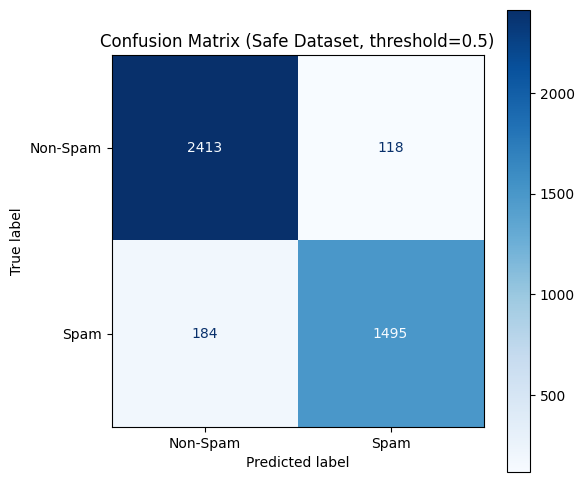

          Pred 0  Pred 1
Actual 0    2413     118
Actual 1     184    1495


In [59]:
# Build formula
target = 'Class'
predictors = [c for c in df_safe.columns if c != target]
formula = f"{target} ~ " + " + ".join(predictors)

# Create design matrices
y_safe, X_safe = dmatrices(formula, df_safe, return_type='dataframe')

# Fit the Logit model
result_safe = sm.Logit(y_safe, X_safe).fit(disp=False)

# Predict and classify
probs_safe = result_safe.predict(X_safe)
y_true = df_safe[target].astype(int)
y_pred = (probs_safe >= 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Spam', 'Spam'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Safe Dataset, threshold=0.5)")
plt.show()

# Print counts
print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))


Every cell in the confusion table has well over the minimum 5-10 observations, showing that **Model 3 Does Not Violate the Assumption of Sample Size.** 
-  True negatives (Actual 0, Pred 0): 2,413
-  False positives (Actual 0, Pred 1): 118
-  False negatives (Actual 1, Pred 0): 184
-  True positives (Actual 1, Pred 1): 1,495

## Linearity in the logit (visual check)

For continuous predictors, logistic regression assumes the log-odds relate approximately linearly to each predictor.

I compute predicted logits and plot each predictor against the logit with a LOWESS smooth.  
If the smooth curve deviates strongly from a straight line, that suggests nonlinearity.

**Implementation note:** If you see a “x and y must be the same size” error, it typically indicates a mismatch between the predictor vector and the logits array (often caused by NA rows, filtering, or index alignment). Ensuring both are derived from the same design matrix (and using `.values.ravel()` consistently) resolves this.


C:\Users\Rania\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


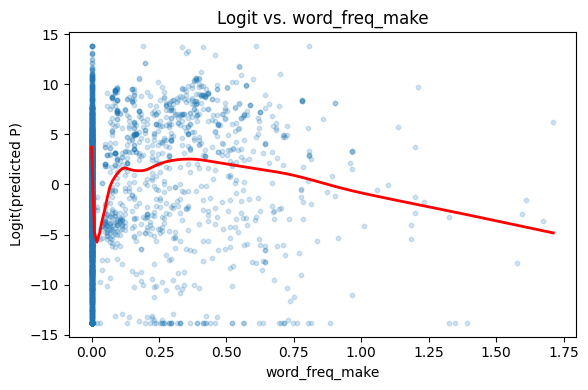

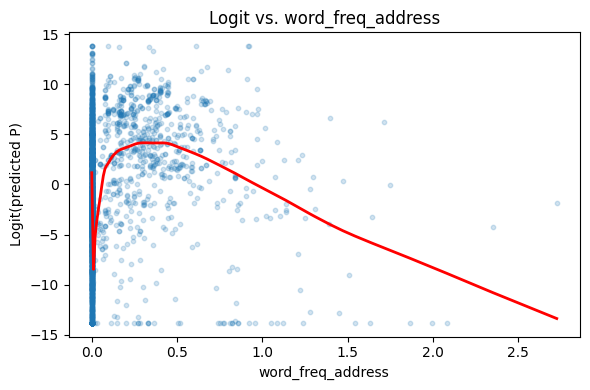

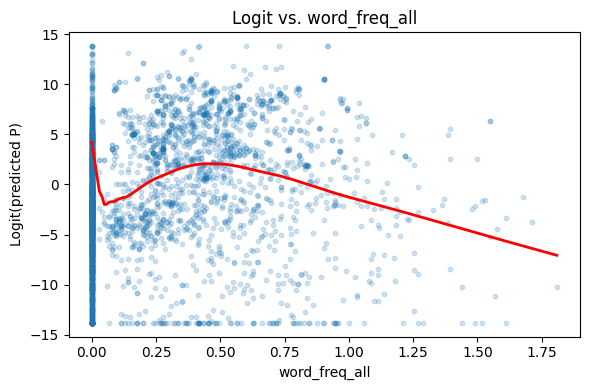

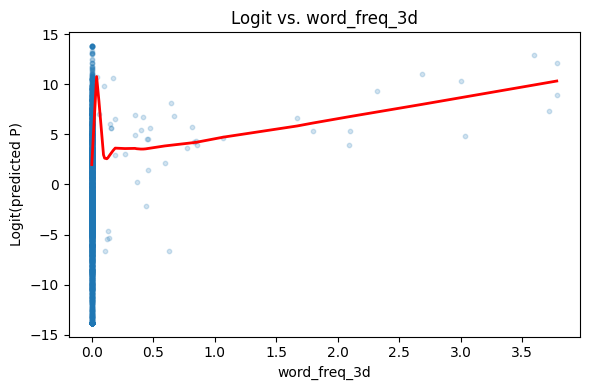

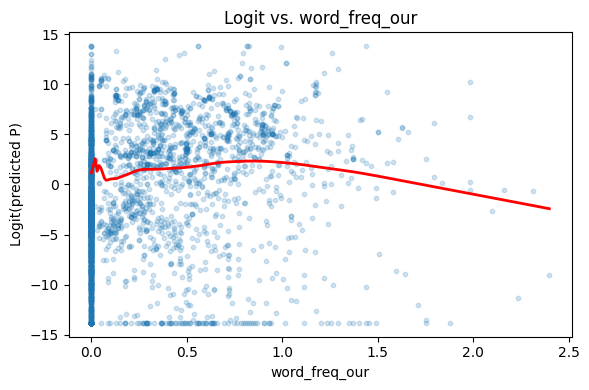

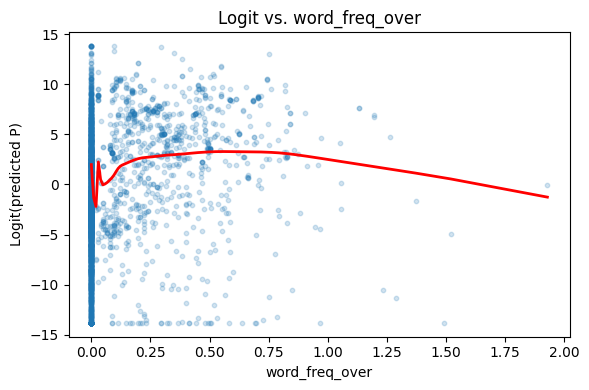

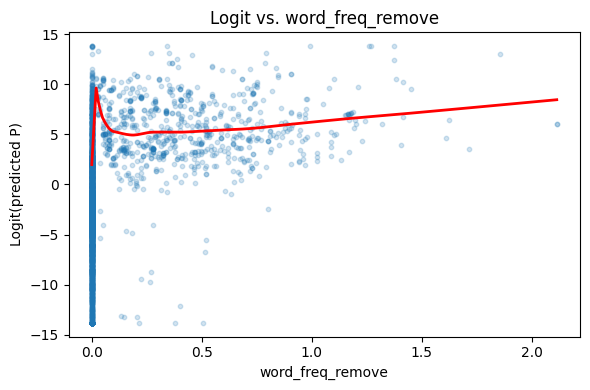

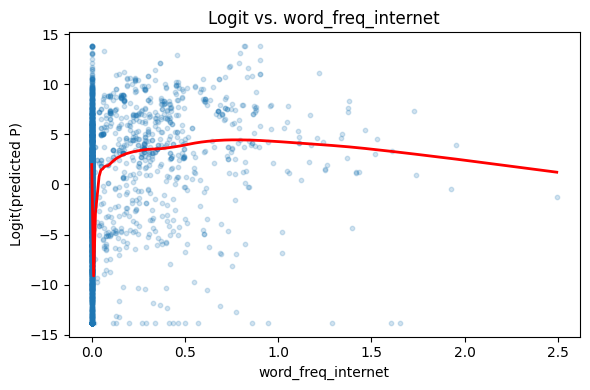

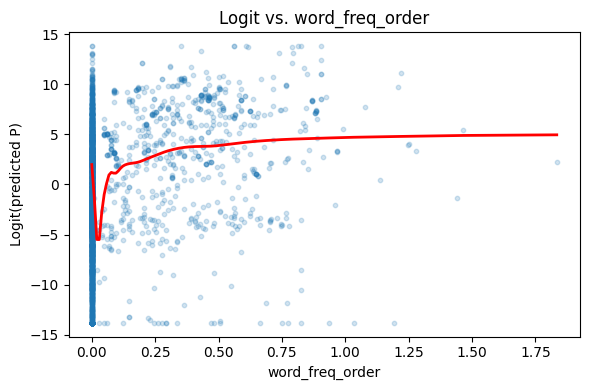

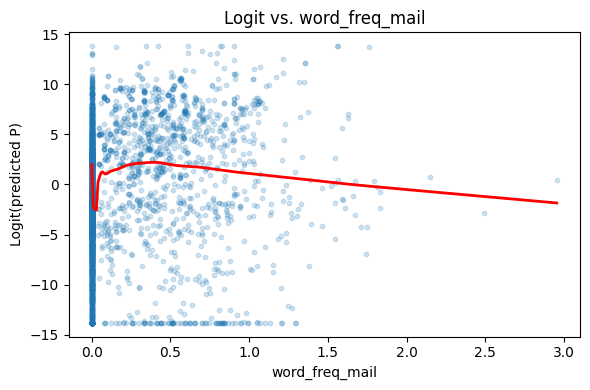

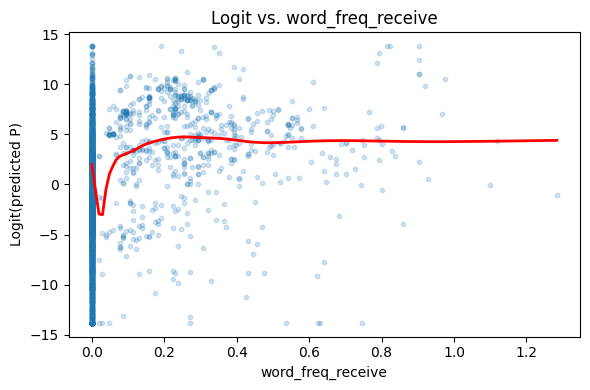

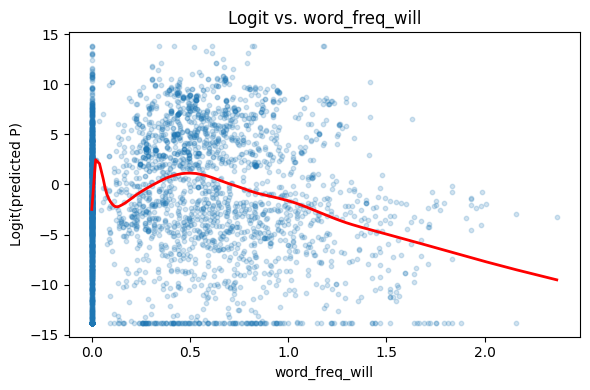

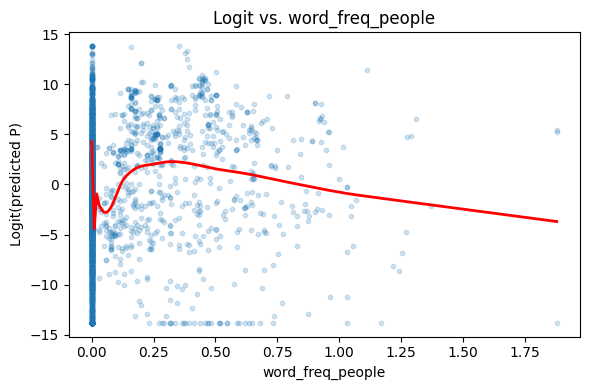

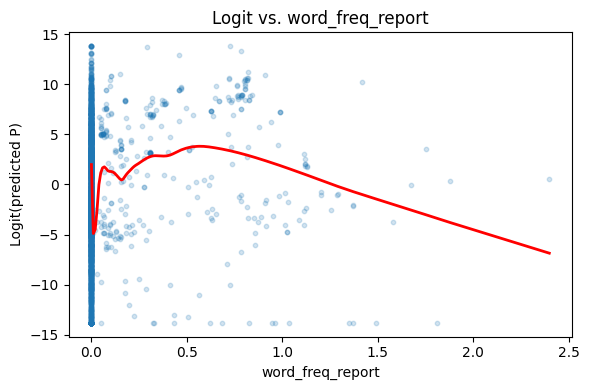

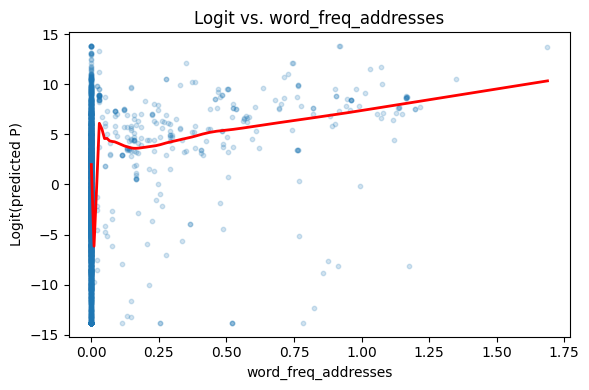

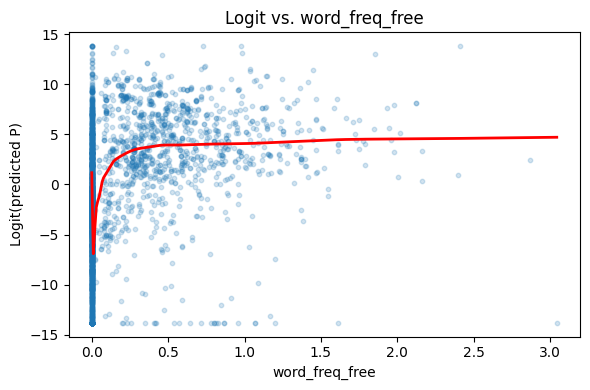

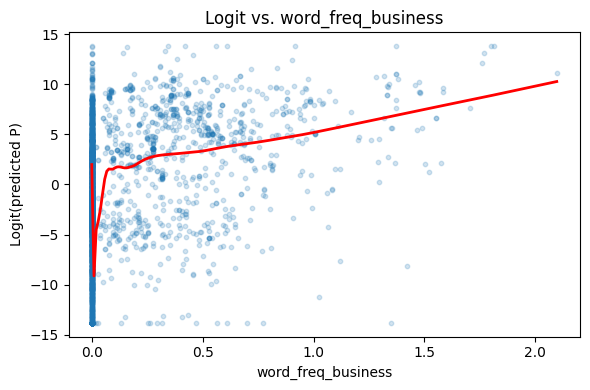

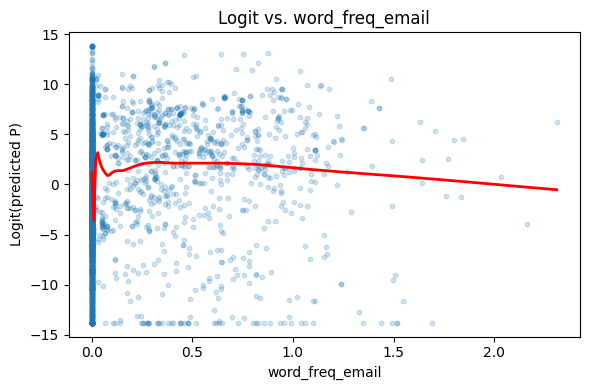

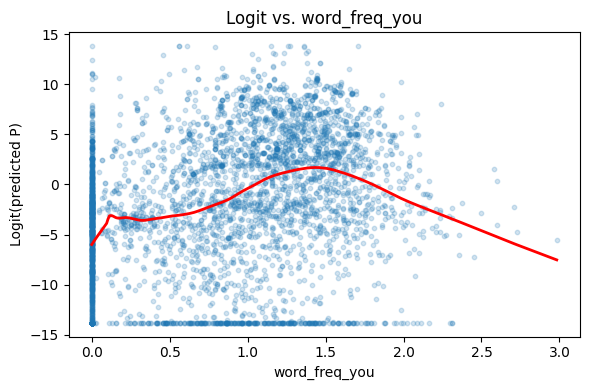

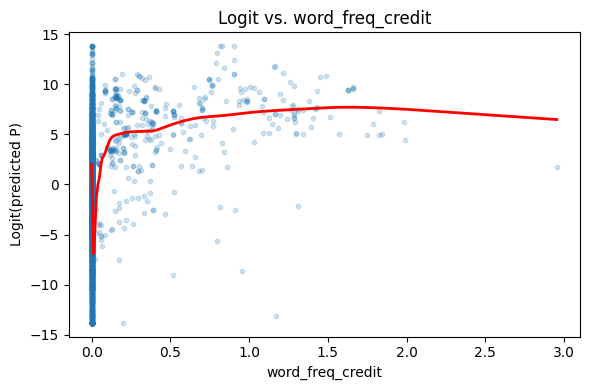

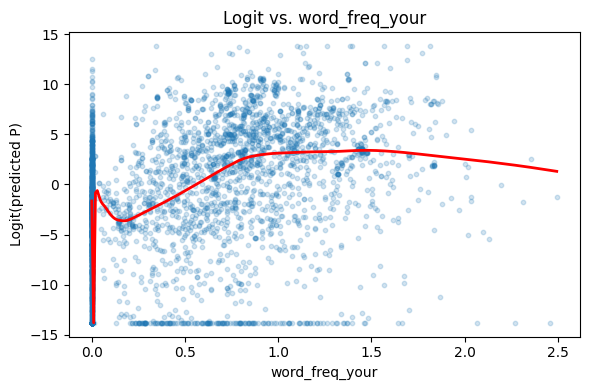

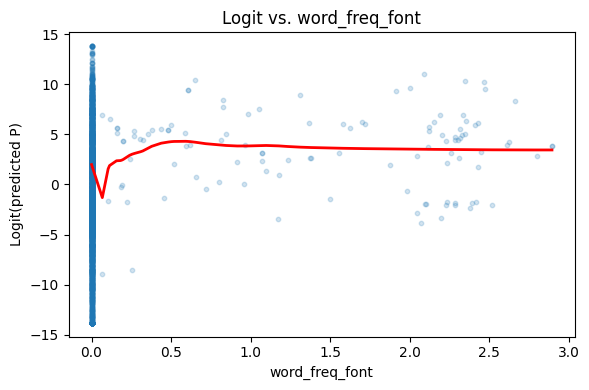

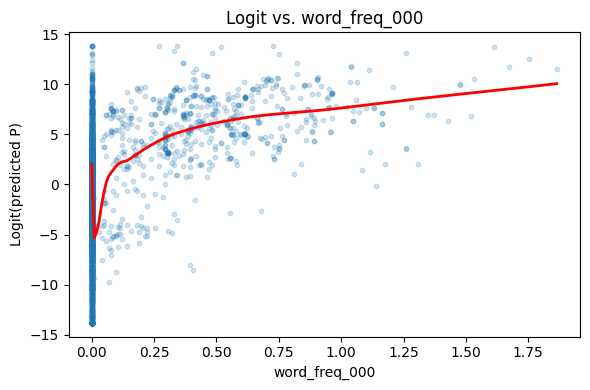

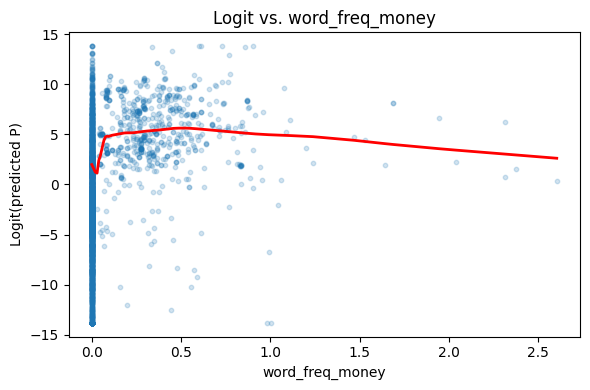

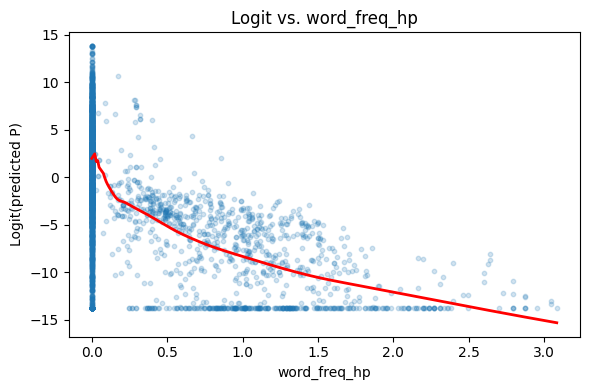

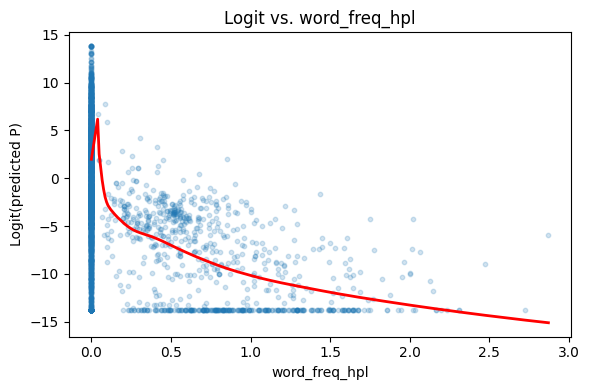

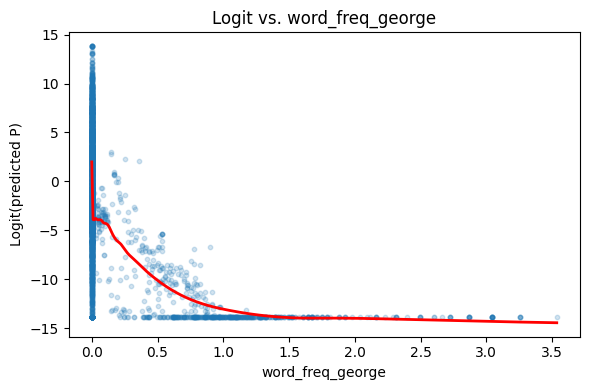

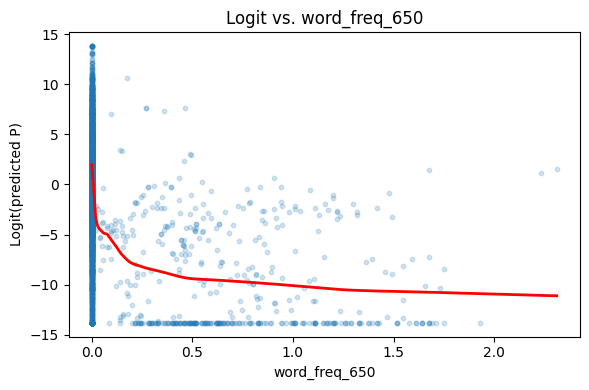

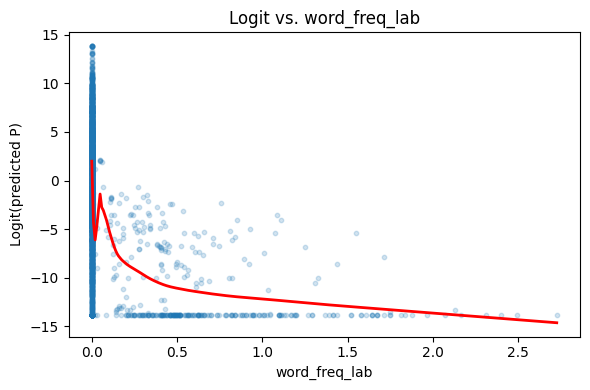

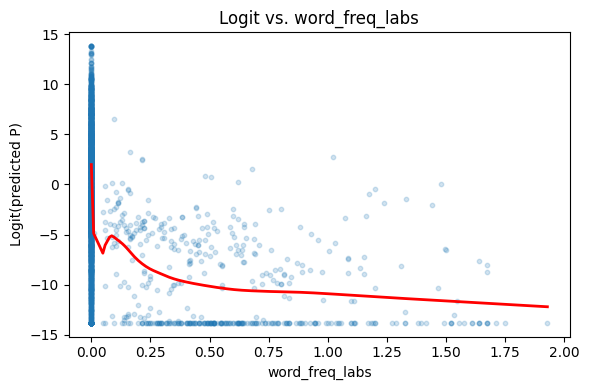

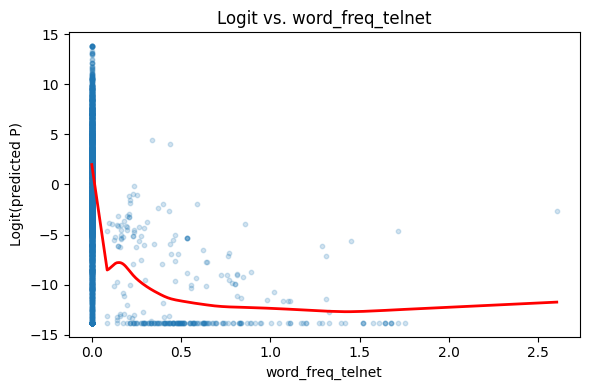

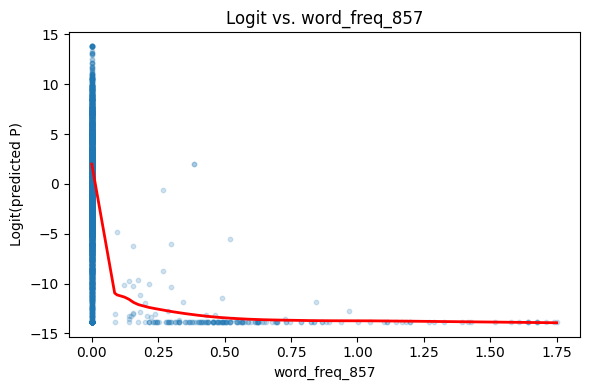

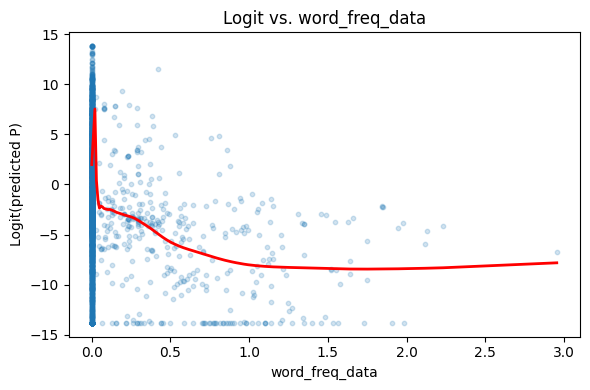

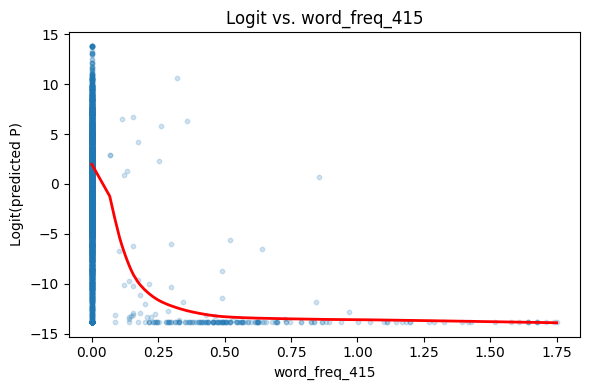

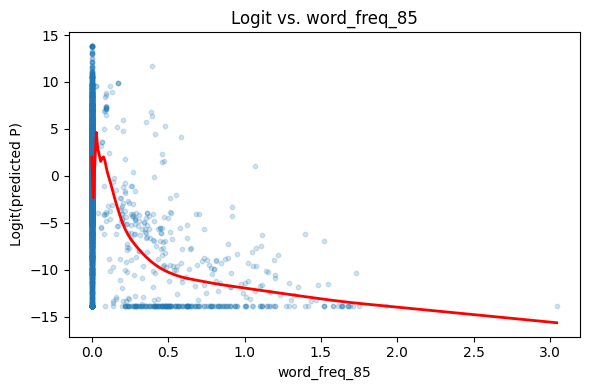

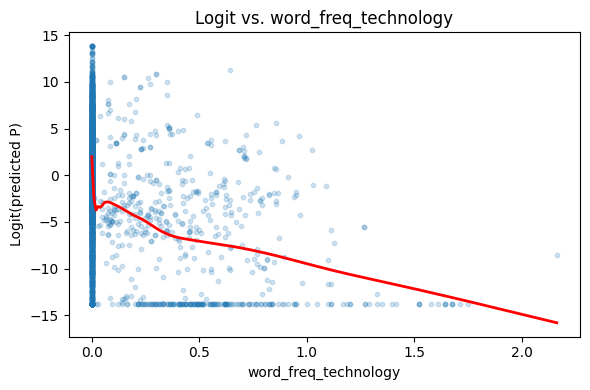

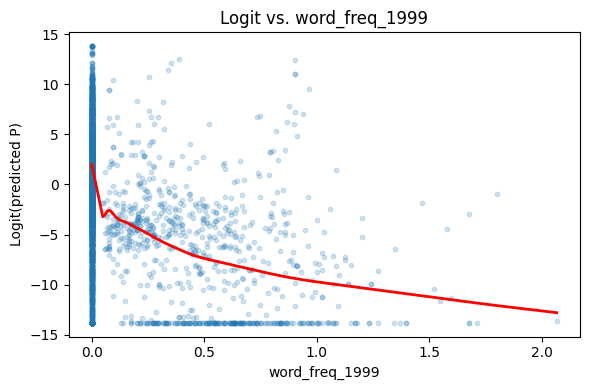

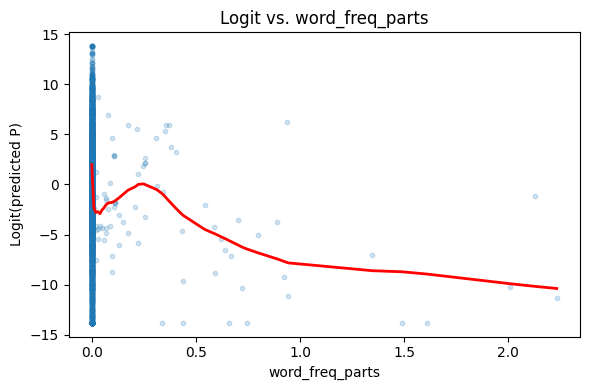

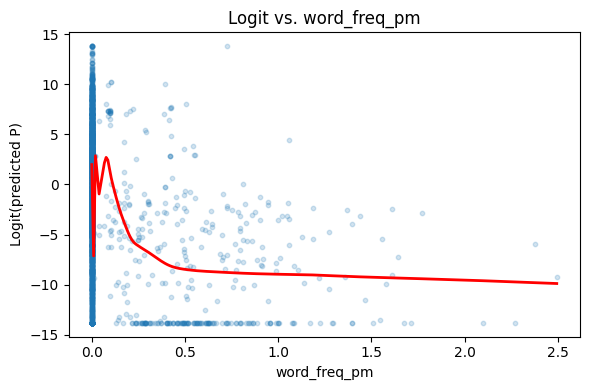

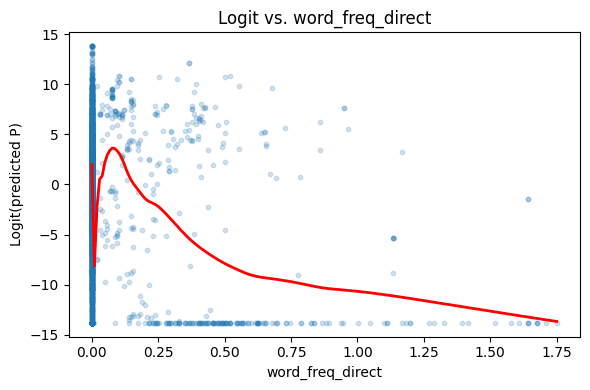

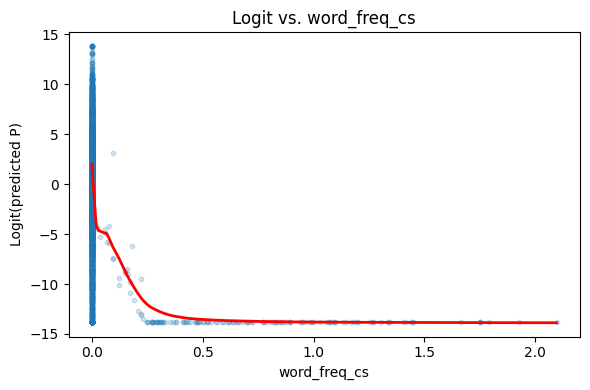

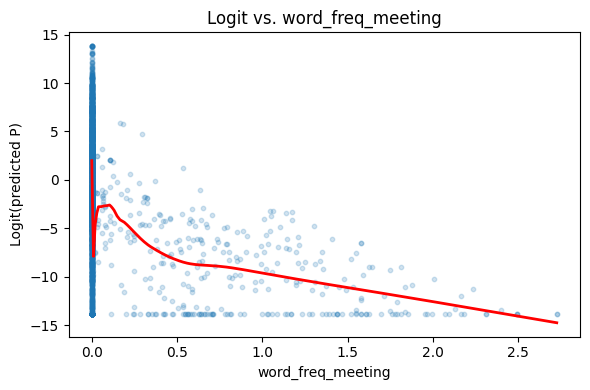

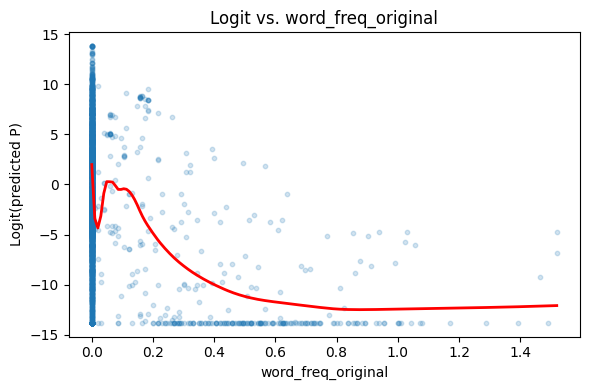

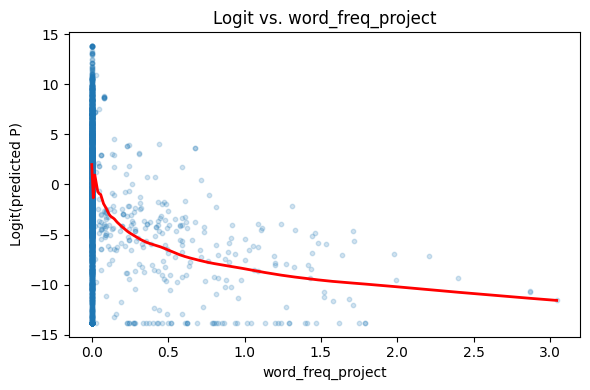

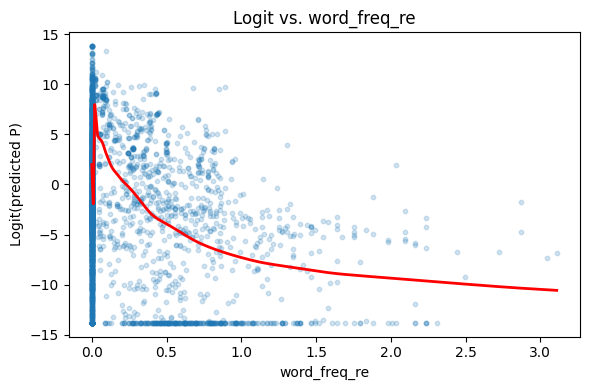

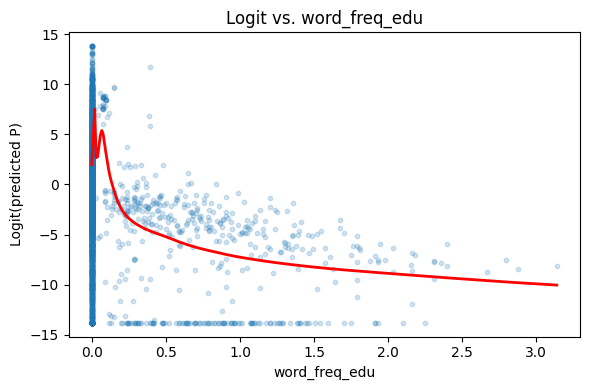

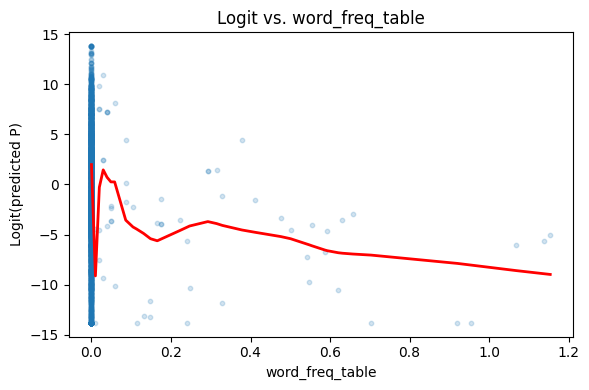

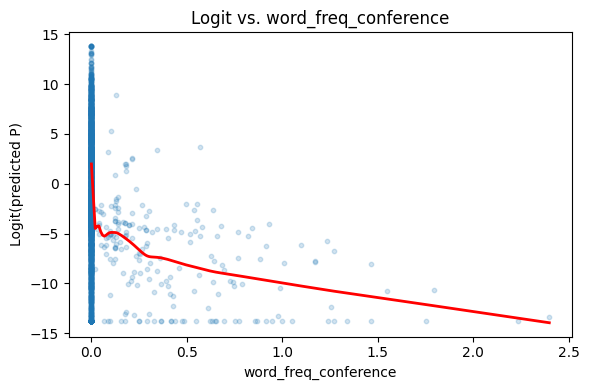

ValueError: x and y must be the same size

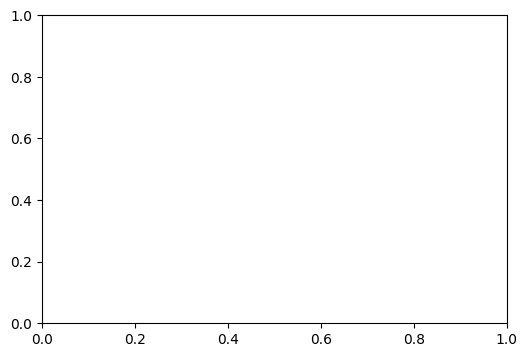

In [60]:
# Sanitize and build design matrices (as before)
df_safe = df_all_log.copy()
safe_map = {c: re.sub(r'[^0-9A-Za-z]+', '_', c).strip('_') for c in df_safe.columns}
df_safe.rename(columns=safe_map, inplace=True)

target = 'Class'
predictors = [c for c in df_safe.columns if c != target]
formula = f"{target} ~ " + " + ".join(predictors)
y, X = dmatrices(formula, df_safe, return_type='dataframe')

# Fit binomial GLM (identical to logistic MLE)
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
result5   = glm_binom.fit()

# Compute predicted probabilities and empirical logit
probs = result5.predict(X)

# Avoid 0 or 1
probs = np.clip(probs, 1e-6, 1-1e-6)
logits = np.log(probs / (1 - probs))

# Plot each predictor vs. logit with Lowess
for feat in predictors:
    fig, ax = plt.subplots(figsize=(6,4))
    x = df_safe[feat].values
    ax.scatter(x, logits, alpha=0.2, s=10)
    
    # Lowess smoothing
    lowess = sm.nonparametric.lowess(logits, x, frac=0.3)
    ax.plot(lowess[:,0], lowess[:,1], color='red', linewidth=2)
    ax.set_xlabel(feat)
    ax.set_ylabel("Logit(predicted P)")
    ax.set_title(f"Logit vs. {feat}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Prepare DataFrames
df_top10_log = df_log[top10_features + ['Class']]
df_all_log   = df_log.copy()

In [ ]:
# Define train/evaluate function
def train_and_evaluate(df, regularize):
    X = df.drop('Class', axis=1)
    y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    if regularize:
        model = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42)
    else:
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred  = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    print(f"\n=== {'With' if regularize else 'No'} Reg | Features: {X.shape[1]} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

In [ ]:
# Run the four models
# Model 1: Top 10, no regularization
train_and_evaluate(df_top10_log, regularize=False)

# Model 2: Top 10, with regularization
train_and_evaluate(df_top10_log, regularize=True)

# Model 3: All 57, no regularization
train_and_evaluate(df_all_log, regularize=False)

# Model 4: All 57, with regularization
train_and_evaluate(df_all_log, regularize=True)

## Multicollinearity (VIF)

Even when pairwise correlations look acceptable, multicollinearity can still exist across many predictors.  
I compute **Variance Inflation Factors (VIF)** to identify features with redundant information that may destabilize coefficient estimates.

In [ ]:
# Calculate VIF to catch remaining multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_all_log.drop("Class", axis=1)
vif_data = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_data.sort_values("VIF", ascending=False))

There are five features with VIF values over the acceptable threshold of 10:

-  'word_freq_415' and 'word_freq_857' are area codes, per the spambase description (2011). Since the features represent the same concept (area codes), summing is the simplest way to collapse them into one features while preserving the "area-code frequency" signal. 
-  the 'capital_run_length_' features are all functions of the same underlying sequences. We basically have the sum of all runs, the average (sum of all runs/num of runs), and the max run. We could pick just one summary feature (the average, most likely) to remove collinearity altogether, but we may end up losing a unique signal that each feature contributes. Therefore, using PCA to fuse them is a better choice. 

In [ ]:
# Combine word_freq_area codes using simple straight sums
df_all_log['word_freq_area_codes'] = (
    df_all_log['word_freq_415'] +
    df_all_log['word_freq_857']
)


# Drop the two originals
df_all_log = df_all_log.drop(columns=['word_freq_415', 'word_freq_857'])

In [ ]:
# Combine capital_run_length features using principal-component reduction
from sklearn.decomposition import PCA

# Extract the three features
caps = df_all_log[[
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total"
]]

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
caps_scaled = scaler.fit_transform(caps)

# Keep just the first principal component
pca = PCA(n_components=1, random_state=42)
df_all_log["caps_PC1"] = pca.fit_transform(caps_scaled)

# Then drop the originals
df_all_log = df_all_log.drop(columns=[
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total"
])


In [ ]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# create Scree plot
plt.figure(figsize=(6, 4))
plt.bar(np.arange(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot for Capital‐Run‐Length PCA")
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.tight_layout()
plt.show()

print("Explained variance ratio: ", explained_variance)

Since the goal was to remove collinearity, a single PC capturing ~82% of the explained variance between the three features is good enough. 

In [ ]:
df_all_log.head()

In [ ]:
# Recalculate VIF
X = df_all_log.drop("Class", axis=1)
vif_data = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_data.sort_values("VIF", ascending=False)).head(10)

All features have VIF values less than 10, thus we can say that we have met the assumption of absence of multicollinearity after transformation and feature engineering. 

In [ ]:
### Recreate models with transformed features for comparison
feature_cols = [c for c in df_all_log.columns if c != "Class"]
df_updated = df_all_log.copy()

# Select top 10 features on transformed data
X_full = df_all_log.drop("Class", axis=1)
y = df_all_log["Class"]
selector = SelectKBest(mutual_info_classif, k=10).fit(X_full, y)
top10_features = X_full.columns[selector.get_support()].tolist()
df_top10_updated = df_all_log[top10_features + ["Class"]]


In [ ]:
# Create function to train/test model
def train_and_evaluate(df, regularize):
    X = df.drop("Class", axis=1)
    y = df["Class"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_train)
    X_te = scaler.transform(X_test)
    if regularize:
        model = LogisticRegression(penalty="l2", solver="liblinear", C=1.0)
    else:
        model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=1000)
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]
    print(f"\n=== {'With' if regularize else 'No'} Reg | Features: {X.shape[1]} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Recreate the models on updated data

# Model 1: top 10, no regularization
train_and_evaluate(df_top10_updated, regularize=False)

# Model 2: top 10, with L2 regularization
train_and_evaluate(df_top10_updated, regularize=True)

# Model 3: all updated features, no regularization
train_and_evaluate(df_updated, regularize=False)

# Model 4: all updated features, with L2 regularization
train_and_evaluate(df_updated, regularize=True)

The accuracy and precision improved slightly for models 1 and 2, while the recall and AUC remains the same. 
For models 3 and 4, spam recall dropped slightly with regularization, but precision increased a bit. The AUC and accuracy remained the same. 

In conclusion, the best overall model performance is with models containing all 54 features. Regularization helps slightly to reduce overfitting (fewer false positives) at the cost of a small drop in catch rate. As we care more about precision (avoiding mis-flagging non-spam) than we do about catching all spam, Model 4 is the best option. 

In [ ]:
# Evaluate the models
# Split into train/test
X = df_updated.drop("Class", axis=1)
y = df_updated["Class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

def evaluate(model, name):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Spam","Spam"])
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(f"{name} Confusion Matrix")
    plt.show()
    
    # print counts
    print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [ ]:
# 3. Model 3: no regularization
evaluate(LogisticRegression(penalty=None, solver="lbfgs", max_iter=1000), "Model 3 (No Reg)")

# 4. Model 4: L2 regularization
evaluate(LogisticRegression(penalty="l2", solver="liblinear", C=1.0), "Model 4 (L2 Reg)")

## Outliers

Outliers remain present (as expected in frequency-style features), but their impact is mitigated through:
- `log1p` transformation
- standardization before model fitting

Given this pipeline, additional outlier removal is not necessary for model stability.

## Independence of errors (approximate diagnostic)

While independence is more naturally framed for time-ordered data, I use residual-based diagnostics (Durbin–Watson on Pearson residuals) as a rough check that errors are not systematically autocorrelated.

In [ ]:
from statsmodels.stats.stattools import durbin_watson

# Sanitize column names in df_updated
df_safe = df_updated.copy()
safe_map = {col: re.sub(r'[^0-9A-Za-z]+','_',col).strip('_') for col in df_safe.columns}
df_safe.rename(columns=safe_map, inplace=True)

# Build formula and design matrices
target = 'Class'
predictors = [c for c in df_safe.columns if c != target]
formula = f"{target} ~ " + " + ".join(predictors)
y, X = dmatrices(formula, df_safe, return_type='dataframe')

# Fit Binomial GLM (logistic regression)
result = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Compute deviance and Pearson residuals
resid_dev  = result.resid_deviance
resid_pear = result.resid_pearson

# Durbin–Watson test
dw_dev  = durbin_watson(resid_dev)
dw_pear = durbin_watson(resid_pear)

print(f"Durbin–Watson on deviance residuals: {dw_dev:.3f}")
print(f"Durbin–Watson on Pearson residuals : {dw_pear:.3f}")

# Plot results
plt.figure(figsize=(6,4))
plt.bar(['Deviance','Pearson'], [dw_dev, dw_pear], color=['C0','C1'])
plt.axhline(2, color='red', linestyle='--', label='Ideal (2)')
plt.ylabel('Durbin–Watson statistic')
plt.title('Independence of Errors (df_updated)')
plt.legend()
plt.tight_layout()
plt.show()

For logistic regression, use Pearson-based test for independence. DW ~ 1.92 on Pearson residuals satisfies the assumption of independence of errors. 

# Conclusion

This project demonstrates an end-to-end workflow for spam classification using logistic regression:

- Removed duplicates to avoid evaluation leakage  
- Used EDA + mutual information to understand informative predictors  
- Improved fit with `log1p` transformation to address skew  
- Diagnosed and reduced multicollinearity using feature engineering (summing redundant features + PCA)  
- Compared regularized and unregularized models using precision/recall and ROC-AUC  

Overall, models trained on the full feature set performed best, and the final selection emphasizes **high precision** to minimize mislabeling legitimate email as spam.
